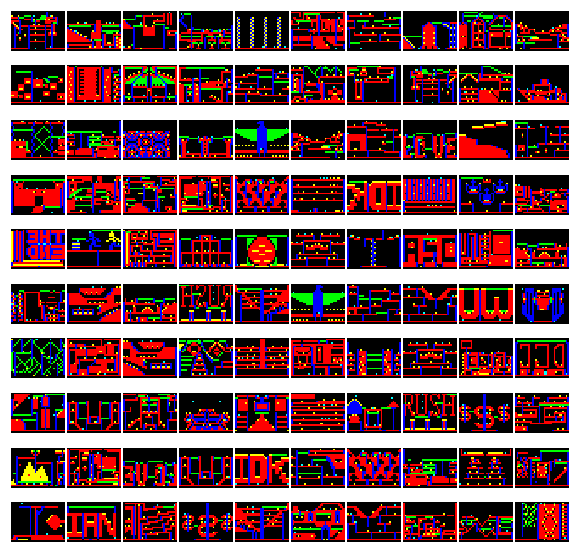

(300, 24, 32, 5)


In [18]:
from __future__ import print_function,division
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import astar

#VAE param
input_path = 'e://python3/cv/levels/lode_runner_5_channel.npy'
gb_w, gb_h, gb_c = 24,32,5
tdata='level'  #level(22*32)*b=1 or mnist(28*28)*b=16
batch_size = 30
total_data = 300
threthod = 0.3
noise_dim = 4   #important part
lr = 1e-3
show_every_img=1000
print_every_loss=100
num_epoch=1000



def translate(images_in):
    images = np.zeros((images_in.shape[0],images_in.shape[1],images_in.shape[2],3),dtype=np.float)
    #R
    images[:,:,:,0] = images_in[:,:,:,0]
    #G
    images[:,:,:,1] = images_in[:,:,:,1]
    #B
    images[:,:,:,2] = images_in[:,:,:,2]
    #yellow
    if gb_c > 3:
        images[tuple(list(np.where(images_in[:,:,:,3]==1))+[np.array([0],dtype=np.int64)])] = 1
        images[tuple(list(np.where(images_in[:,:,:,3]==1))+[np.array([1],dtype=np.int64)])] = 1
    #cyan
    if gb_c > 4:
        images[tuple(list(np.where(images_in[:,:,:,4]==1))+[np.array([1],dtype=np.int64)])] = 1
        images[tuple(list(np.where(images_in[:,:,:,4]==1))+[np.array([2],dtype=np.int64)])] = 1
    return images

def disp_images(images,figsize=None):
    images_sv = np.reshape(images,[-1,gb_w,gb_h,gb_c])
    outlist = images_sv
    images = translate(images_sv)
    images = np.reshape(images,[images.shape[0],-1])
    if threthod!=None:
        images[images>=threthod] = 1.0
        images[images<threthod] = 0.0
    sqrtn = min(int(np.ceil(np.sqrt(images.shape[0]))),10)
    if figsize:
        plt.figure(figsize = figsize)
    else:
        figure = plt.figure(figsize = (sqrtn,sqrtn))
    gs = gridspec.GridSpec(sqrtn,sqrtn)
    gs.update(wspace = 0.05,hspace = 0.05)
    for i,img in enumerate(images):
        tmp = img.reshape([gb_w,gb_h,3])
        if i<100:
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')            
            plt.imshow(tmp) #
    plt.show()
    return outlist


def preprocess(x):
    return 2*x-1.0
def deprocess(x):
    return (x+1.0) / 2.0

def session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config = config)
    return session
def activation(x, alpha = 0.01):# leaky relu
    a = tf.maximum(x,alpha*x)
    return a

def get_solvers(lr = 1e-3, beta1 = 0.5):
    d_solver = tf.train.AdamOptimizer(learning_rate = lr,beta1 = beta1)
    return d_solver

def threthod_func(tin,threthod = 0.5):
    one = tf.ones_like(tin)
    zero = tf.zeros_like(tin)
    tin = tf.where(tin < threthod, x=zero, y=one)
    return tin

def data_augumentation(tin):
    return tin[:,:,::-1,:]

class batch_iter:
    def __init__(self,data,batch_size):
        self.data = data.reshape([data.shape[0],-1])
        self.batch_size = batch_size
        self.iter = 0
    def next_batch(self):
        if self.iter>=len(self.data): 
            np.random.shuffle(self.data)        
            self.iter = 0
        tmp = self.iter
        self.iter += self.batch_size
        return self.data[tmp:tmp+batch_size]

if tdata == 'level':
    imageMatrix1 = np.load(input_path)[:150]
    imageMatrix2 = data_augumentation(imageMatrix1)
    imageMatrix1 = np.vstack((imageMatrix1,imageMatrix2))
    np.random.shuffle(imageMatrix1)
    imageMatrix1 = imageMatrix1[0:total_data]  #----------------------------------
    disp_images(imageMatrix1)
    print(imageMatrix1.shape)
    '''path = "e://python3/cv/"
    file1="shang.png"#"2.jpg"#"chang.png""checker128-var20.png"
    img1 = Image.open(path+str(file1)) 
    imageMatrix1 = np.matrix(img1.getdata())
    def grey_kernel(matrix,L):
        new = np.zeros(matrix.shape[0])
        for i in range(matrix.shape[0]):
            new[i]=np.uint8(round(0.299*matrix[i,0]+0.587*matrix[i,1]+0.114*matrix[i,2]))#matrix[i,0]#      
        return new
    imageMatrix1 = grey_kernel(imageMatrix1,256)
    imageMatrix1 = np.reshape(imageMatrix1,[1,-1])
    disp_images(imageMatrix1)
    print(imageMatrix1.shape)'''
if tdata == 'mnist':
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets('MNIST_data',one_hot = False)
    disp_images(mnist.train.next_batch(16)[0])# [0] stands for batch x, [1] stands for batch y
    print(mnist.train.next_batch(16)[0].shape) #one global para 12
    print(type(mnist))


In [23]:
def gaussian_MLP_encoder(x_in): #input should be with intensity 0~1
    with tf.variable_scope("encoder"):
        init = tf.contrib.layers.xavier_initializer()
        x_in = preprocess(x_in)
        fc1 = tf.layers.dense(inputs=x_in,units=max(gb_w,gb_h)**2*gb_c, #batch*32*32*3
                              activation=tf.nn.relu,kernel_initializer = init,name='dense_0')
        
        cv2 = fc1
        fc1 = tf.reshape(fc1,[-1,max(gb_w,gb_h),max(gb_w,gb_h),gb_c])
        
        cv1 = tf.layers.conv2d(fc1,8,4,strides=2,padding='same',  #batch*16*16*8
                            kernel_initializer=init,name='e_conv_1')
        cv1 = tf.layers.batch_normalization(cv1,name='e_batchnorm_1')
        cv1 = activation(cv1) 
        cv2 = tf.layers.conv2d(cv1,16,4,strides=2,padding='same',  #batch*8*8*16
                            kernel_initializer=init,name='e_conv_2')
        cv2 = tf.layers.batch_normalization(cv2,name='e_batchnorm_2')
        cv2 = activation(cv2) 
        cv2 = tf.reshape(cv2,[-1,8*8*16])
        
        '''cv2 = tf.nn.dropout(cv2,keep_prob=0.5)'''
        gaussian_params = tf.layers.dense(inputs=cv2,units=noise_dim*2,
                                          kernel_initializer = init,name='dense_3')
        n_output = gaussian_params.shape[1]//2
        mean = gaussian_params[:,:n_output]
        stddev = 1e-6 + tf.nn.softplus(gaussian_params[:,n_output:])
        return mean, stddev
def bernoulli_MLP_decoder(z_in):
    with tf.variable_scope("decoder"):
        init = tf.contrib.layers.xavier_initializer()
        '''z_in = tf.nn.dropout(z_in,keep_prob=0.5)'''
        fc1 = tf.layers.dense(inputs=z_in,units=8*8*16,activation=tf.nn.relu,kernel_initializer = init,name='dense_11')
        
        
        fc1 = tf.reshape(fc1,[-1,8,8,16]) 
        
        cv1 = tf.layers.conv2d_transpose(fc1,filters=8,kernel_size=4,strides=2,padding='same', #batch*16*16*8
                                                kernel_initializer=init,name='d_deconv_1')
        cv1 = tf.layers.batch_normalization(cv1,name='d_batchnorm_1')
        cv1 = tf.nn.relu(cv1)
        
        cv2 = tf.layers.conv2d_transpose(cv1,filters=gb_c,kernel_size=4,strides=2,padding='same', #batch*32*32*3
                                                kernel_initializer=init,name='d_deconv_2')
        cv2 = tf.layers.batch_normalization(cv2,name='d_batchnorm_2')
        cv2 = tf.nn.relu(cv2)        
        cv2 = tf.reshape(cv2,[-1,max(gb_w,gb_h)**2*gb_c]) 
        
        
        fc2 = tf.layers.dense(inputs=cv2,units=gb_w*gb_h*gb_c,
                              kernel_initializer = init,name='dense_00') #11111
        fc2 = tf.nn.sigmoid(fc2)

        #fc2 = threthod_func(fc2,threthod = 0.5)
        return fc2  #output is with intensity 0~1

     
def autoencoder(x):
    with tf.variable_scope("autoencoder"):
        mu, sigma = gaussian_MLP_encoder(x)
        z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)
        #z = tf.nn.tanh(z)
        y = bernoulli_MLP_decoder(z)
        marginal_likelihood = tf.reduce_sum(x*tf.log(1e-6+y)+(1-x)*tf.log(1e-6+1-y),1)
        KL_divergence = 10*0.5 * tf.reduce_sum(tf.square(mu)+tf.square(sigma) - tf.log(1e-8 + tf.square(sigma))-1, 1)

        ELBO = tf.reduce_mean(marginal_likelihood) - tf.reduce_mean(KL_divergence)
        loss = -ELBO

        return y, z, loss, -tf.reduce_mean(marginal_likelihood), tf.reduce_mean(KL_divergence),mu,sigma
    
def train(sess,D_train_step,D_loss,show_every=50,print_every=10,batch_size=1,num_epoch=10):
    if tdata=='level':
        come_in_data = imageMatrix1 #np.random.uniform(0,1,size=[1,22*32]) 
        data = batch_iter(come_in_data,batch_size)
        max_iter = int(len(data.data)*num_epoch/batch_size)
    elif tdata=='mnist':
        max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        if it and (it % show_every == 0):
            print('generated img')
            sap_noise = np.random.normal(0, 1,[16,noise_dim])
            samples = sess.run(output_real, feed_dict = {latent: sap_noise})
            fig = disp_images(samples[:batch_size if batch_size<16 else 16])# one global para

            print()
        #fetch the minibatch and train
        if tdata=='level':
            minibatch = data.next_batch()
        elif tdata=='mnist':
            minibatch,_ = mnist.train.next_batch(batch_size)
        
        _,D_loss_curr,opr,tml,tkl,m,s = sess.run([D_train_step,D_loss,output_real,ml,kl,mu,sigma],feed_dict = {x:minibatch})
        if D_loss_curr<-(10e5): break  
        if it and (it % show_every == 0):
            print('test img')            
            disp_images(opr[:batch_size if batch_size<16 else 16])  # one global para
   
        if (it % print_every == 0):
            print('Iter:{}, loss:{:.4}'.format(it,D_loss_curr))
            print('   encoder_loss:{:.4}, decoder_loss:{:.4}'.format(tml,tkl))


    print('Final images')
    sap_noise = np.random.normal(0, 1,[100,noise_dim])
    samples = sess.run(output_real, feed_dict = {latent: sap_noise})
    fig = disp_images(samples)# one global para

Iter:0, loss:2.666e+03
   encoder_loss:2.661e+03, decoder_loss:4.817
Iter:100, loss:778.8
   encoder_loss:775.0, decoder_loss:3.729
Iter:200, loss:790.9
   encoder_loss:774.8, decoder_loss:16.09
Iter:300, loss:787.3
   encoder_loss:765.8, decoder_loss:21.49
Iter:400, loss:703.8
   encoder_loss:674.5, decoder_loss:29.37
Iter:500, loss:737.8
   encoder_loss:700.4, decoder_loss:37.33
Iter:600, loss:731.5
   encoder_loss:690.6, decoder_loss:40.92
Iter:700, loss:755.0
   encoder_loss:708.6, decoder_loss:46.45
Iter:800, loss:702.4
   encoder_loss:649.0, decoder_loss:53.43
Iter:900, loss:633.0
   encoder_loss:574.2, decoder_loss:58.83
generated img


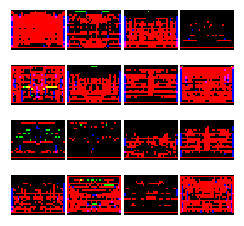


test img


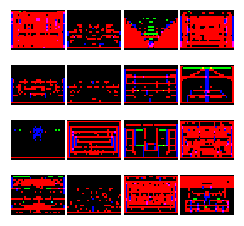

Iter:1000, loss:611.8
   encoder_loss:545.9, decoder_loss:65.85
Iter:1100, loss:647.0
   encoder_loss:579.4, decoder_loss:67.6
Iter:1200, loss:576.3
   encoder_loss:508.0, decoder_loss:68.28
Iter:1300, loss:514.7
   encoder_loss:443.9, decoder_loss:70.76
Iter:1400, loss:472.7
   encoder_loss:374.9, decoder_loss:97.88
Iter:1500, loss:451.6
   encoder_loss:363.8, decoder_loss:87.76
Iter:1600, loss:395.6
   encoder_loss:307.9, decoder_loss:87.71
Iter:1700, loss:497.0
   encoder_loss:410.4, decoder_loss:86.65
Iter:1800, loss:388.2
   encoder_loss:292.1, decoder_loss:96.07
Iter:1900, loss:311.2
   encoder_loss:201.4, decoder_loss:109.7
generated img


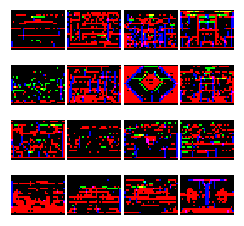


test img


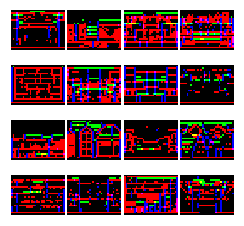

Iter:2000, loss:327.0
   encoder_loss:229.5, decoder_loss:97.5
Iter:2100, loss:248.5
   encoder_loss:146.2, decoder_loss:102.3
Iter:2200, loss:242.5
   encoder_loss:136.4, decoder_loss:106.1
Iter:2300, loss:705.7
   encoder_loss:622.3, decoder_loss:83.45
Iter:2400, loss:199.9
   encoder_loss:96.55, decoder_loss:103.4
Iter:2500, loss:653.1
   encoder_loss:564.3, decoder_loss:88.82
Iter:2600, loss:165.7
   encoder_loss:59.55, decoder_loss:106.1
Iter:2700, loss:167.9
   encoder_loss:62.01, decoder_loss:105.8
Iter:2800, loss:150.3
   encoder_loss:44.61, decoder_loss:105.6
Iter:2900, loss:135.4
   encoder_loss:24.99, decoder_loss:110.4
generated img


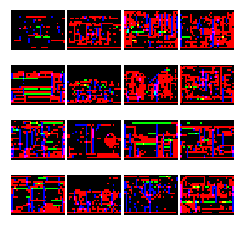


test img


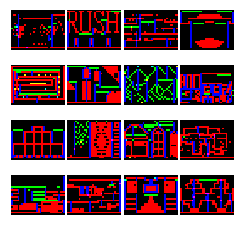

Iter:3000, loss:135.5
   encoder_loss:30.83, decoder_loss:104.7
Iter:3100, loss:436.5
   encoder_loss:342.1, decoder_loss:94.44
Iter:3200, loss:142.5
   encoder_loss:34.06, decoder_loss:108.4
Iter:3300, loss:117.8
   encoder_loss:16.86, decoder_loss:101.0
Iter:3400, loss:114.0
   encoder_loss:20.65, decoder_loss:93.36
Iter:3500, loss:126.3
   encoder_loss:24.96, decoder_loss:101.3
Iter:3600, loss:121.5
   encoder_loss:20.42, decoder_loss:101.0
Iter:3700, loss:113.8
   encoder_loss:11.64, decoder_loss:102.2
Iter:3800, loss:503.3
   encoder_loss:402.3, decoder_loss:101.0
Iter:3900, loss:290.8
   encoder_loss:185.5, decoder_loss:105.3
generated img


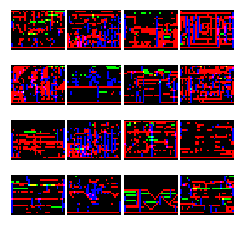


test img


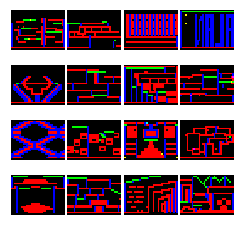

Iter:4000, loss:108.6
   encoder_loss:14.24, decoder_loss:94.36
Iter:4100, loss:107.0
   encoder_loss:13.89, decoder_loss:93.07
Iter:4200, loss:106.9
   encoder_loss:9.088, decoder_loss:97.79
Iter:4300, loss:112.4
   encoder_loss:11.16, decoder_loss:101.3
Iter:4400, loss:686.1
   encoder_loss:574.0, decoder_loss:112.1
Iter:4500, loss:110.9
   encoder_loss:11.48, decoder_loss:99.44
Iter:4600, loss:105.8
   encoder_loss:11.58, decoder_loss:94.22
Iter:4700, loss:434.1
   encoder_loss:327.8, decoder_loss:106.3
Iter:4800, loss:113.0
   encoder_loss:20.04, decoder_loss:92.93
Iter:4900, loss:109.3
   encoder_loss:12.62, decoder_loss:96.72
generated img


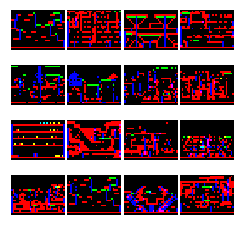


test img


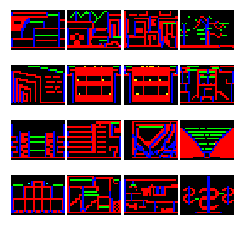

Iter:5000, loss:108.2
   encoder_loss:12.94, decoder_loss:95.27
Iter:5100, loss:110.0
   encoder_loss:12.86, decoder_loss:97.1
Iter:5200, loss:114.3
   encoder_loss:17.4, decoder_loss:96.89
Iter:5300, loss:136.8
   encoder_loss:31.75, decoder_loss:105.0
Iter:5400, loss:413.5
   encoder_loss:301.7, decoder_loss:111.8
Iter:5500, loss:112.7
   encoder_loss:18.04, decoder_loss:94.67
Iter:5600, loss:101.6
   encoder_loss:12.43, decoder_loss:89.13
Iter:5700, loss:112.3
   encoder_loss:12.59, decoder_loss:99.76
Iter:5800, loss:109.7
   encoder_loss:23.08, decoder_loss:86.63
Iter:5900, loss:102.2
   encoder_loss:11.72, decoder_loss:90.48
generated img


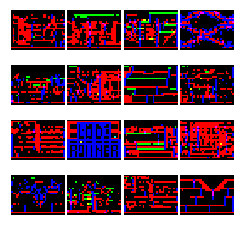


test img


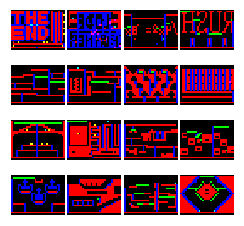

Iter:6000, loss:109.9
   encoder_loss:7.076, decoder_loss:102.8
Iter:6100, loss:113.9
   encoder_loss:20.19, decoder_loss:93.68
Iter:6200, loss:108.1
   encoder_loss:14.82, decoder_loss:93.33
Iter:6300, loss:106.3
   encoder_loss:12.74, decoder_loss:93.54
Iter:6400, loss:104.4
   encoder_loss:4.508, decoder_loss:99.91
Iter:6500, loss:584.9
   encoder_loss:490.9, decoder_loss:93.98
Iter:6600, loss:107.3
   encoder_loss:8.334, decoder_loss:98.92
Iter:6700, loss:98.27
   encoder_loss:6.803, decoder_loss:91.47
Iter:6800, loss:107.4
   encoder_loss:14.02, decoder_loss:93.37
Iter:6900, loss:97.2
   encoder_loss:12.43, decoder_loss:84.78
generated img


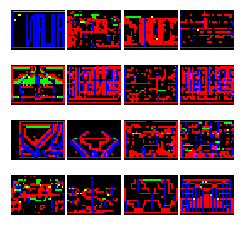


test img


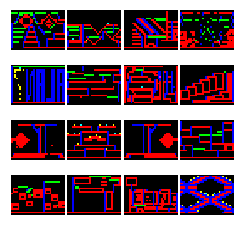

Iter:7000, loss:109.5
   encoder_loss:20.03, decoder_loss:89.49
Iter:7100, loss:100.8
   encoder_loss:7.183, decoder_loss:93.57
Iter:7200, loss:116.7
   encoder_loss:5.29, decoder_loss:111.4
Iter:7300, loss:117.7
   encoder_loss:22.03, decoder_loss:95.62
Iter:7400, loss:113.5
   encoder_loss:23.45, decoder_loss:90.02
Iter:7500, loss:123.4
   encoder_loss:31.6, decoder_loss:91.79
Iter:7600, loss:686.5
   encoder_loss:590.1, decoder_loss:96.39
Iter:7700, loss:103.5
   encoder_loss:3.644, decoder_loss:99.84
Iter:7800, loss:100.7
   encoder_loss:5.278, decoder_loss:95.42
Iter:7900, loss:97.35
   encoder_loss:8.14, decoder_loss:89.21
generated img


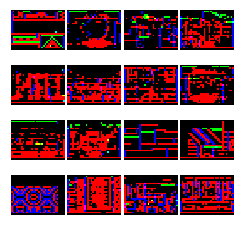


test img


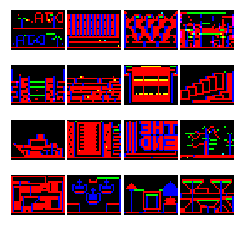

Iter:8000, loss:98.96
   encoder_loss:12.58, decoder_loss:86.38
Iter:8100, loss:100.2
   encoder_loss:13.31, decoder_loss:86.89
Iter:8200, loss:100.7
   encoder_loss:9.261, decoder_loss:91.45
Iter:8300, loss:104.6
   encoder_loss:5.944, decoder_loss:98.63
Iter:8400, loss:110.7
   encoder_loss:8.723, decoder_loss:102.0
Iter:8500, loss:104.9
   encoder_loss:6.025, decoder_loss:98.86
Iter:8600, loss:98.07
   encoder_loss:5.12, decoder_loss:92.95
Iter:8700, loss:102.8
   encoder_loss:17.89, decoder_loss:84.87
Iter:8800, loss:116.5
   encoder_loss:31.38, decoder_loss:85.17
Iter:8900, loss:102.4
   encoder_loss:8.311, decoder_loss:94.07
generated img


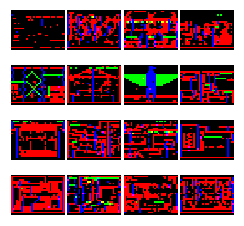


test img


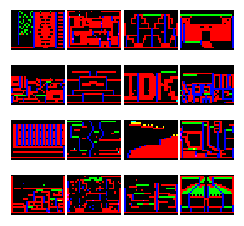

Iter:9000, loss:122.2
   encoder_loss:29.78, decoder_loss:92.46
Iter:9100, loss:94.46
   encoder_loss:5.817, decoder_loss:88.64
Iter:9200, loss:99.61
   encoder_loss:9.078, decoder_loss:90.53
Iter:9300, loss:122.4
   encoder_loss:31.27, decoder_loss:91.13
Iter:9400, loss:96.19
   encoder_loss:5.133, decoder_loss:91.06
Iter:9500, loss:96.02
   encoder_loss:3.613, decoder_loss:92.4
Iter:9600, loss:110.3
   encoder_loss:22.76, decoder_loss:87.49
Iter:9700, loss:95.45
   encoder_loss:9.597, decoder_loss:85.85
Iter:9800, loss:111.0
   encoder_loss:20.69, decoder_loss:90.28
Iter:9900, loss:110.3
   encoder_loss:14.54, decoder_loss:95.75
Final images


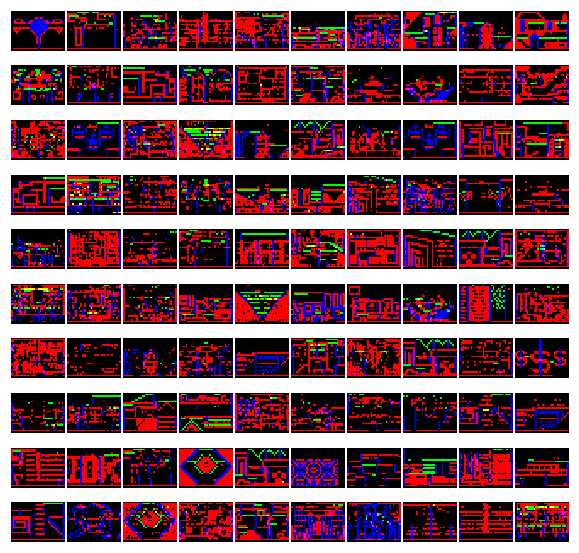

In [24]:
tf.reset_default_graph()
#batch_size = 16
#noise_dim = 50   #important part
x = tf.placeholder(tf.float32,[None,gb_w*gb_h*gb_c]) #-----------------------------------------

output_real, latent, d_loss, ml, kl, mu, sigma = autoencoder(x)


d_solver = get_solvers(lr=lr)
d_train_step = d_solver.minimize(d_loss)

sess = session()
try:
    with tf.device("/cpu:0") as dev:
        sess.run(tf.global_variables_initializer())
        train(sess,d_train_step,d_loss,show_every=show_every_img,print_every=print_every_loss,batch_size=batch_size, num_epoch=num_epoch)    
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration") 

    


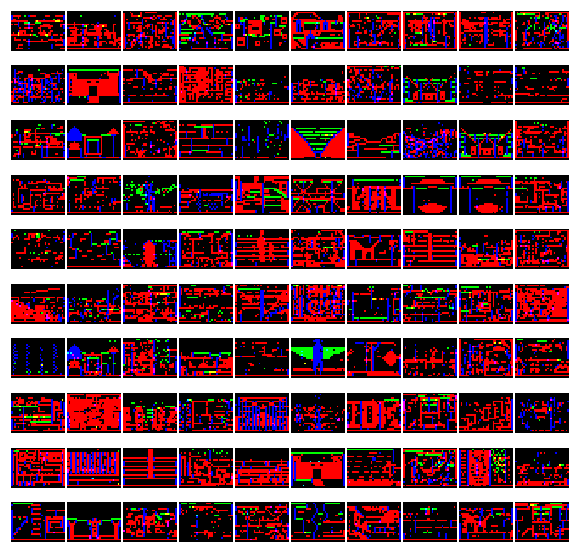

(10000, 24, 32, 5)


In [25]:
generate_num = 9700
sap_noise = np.random.normal(0, 1,[generate_num,noise_dim])
samples = sess.run(output_real, feed_dict = {latent: sap_noise})
fig = disp_images(samples)# one global para\
img_save = np.vstack((fig,imageMatrix1))
np.random.shuffle(img_save)
np.save("vae_v5",img_save,allow_pickle=False,fix_imports=True)
sth = np.load("e://python3/vae_v5.npy")

print(sth.shape)

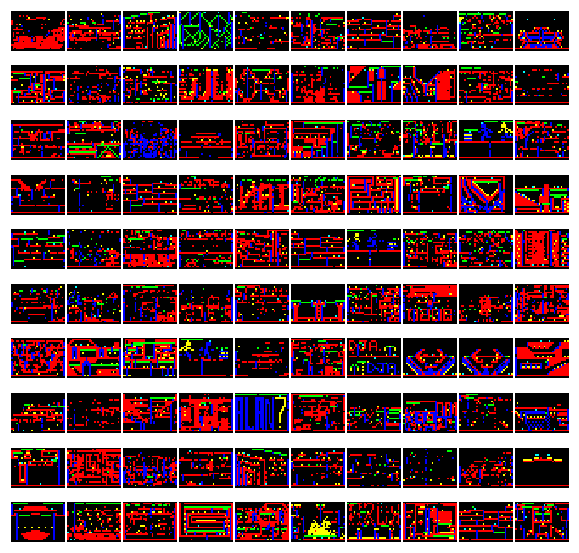

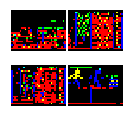

(4, 3840)


In [32]:
sth = np.load("e://python3/vae_v5.npy")
ec_imglist = []
for i in range(sth.shape[0]):
    #print('process ',i)
    _, ec_img  = Util.encoding_img(sth[i])
    ec_imglist.append(ec_img)
ec_imglist = np.array(ec_imglist)
_ = Util.disp_images(ec_imglist[1200:1300])
ec_picked = ec_imglist[[1012,1049,1178,1263]]
_ = Util.disp_images(ec_picked)
print(ec_picked.shape)
np.save("visualizevae_v5",ec_picked,allow_pickle=False,fix_imports=True)

In [5]:
#sess.close()

In [6]:
#----evolution
class Util:
    def img2gene(level_in):  #[150,22,32,3]
        #if not level_in: return 'error'
        gene = level_in.reshape([level_in.shape[0],-1])
        return gene  #output 150,22*32,3
    def translate(images_in):
        images = np.zeros((images_in.shape[0],images_in.shape[1],images_in.shape[2],3),dtype=np.float)
        #R
        images[:,:,:,0] = images_in[:,:,:,0]
        #G
        images[:,:,:,1] = images_in[:,:,:,1]
        #B
        images[:,:,:,2] = images_in[:,:,:,2]
        #yellow
        if gb_c > 3:
            images[tuple(list(np.where(images_in[:,:,:,3]==1))+[np.array([0],dtype=np.int64)])] = 1
            images[tuple(list(np.where(images_in[:,:,:,3]==1))+[np.array([1],dtype=np.int64)])] = 1
        #cyan
        if gb_c > 4:
            images[tuple(list(np.where(images_in[:,:,:,4]==1))+[np.array([1],dtype=np.int64)])] = 1
            images[tuple(list(np.where(images_in[:,:,:,4]==1))+[np.array([2],dtype=np.int64)])] = 1
        return images

    def disp_images(images,threthod=0.3,figsize=None,gb_w=gb_w,gb_h=gb_h,gb_c=gb_c):
        images_sv = np.reshape(images,[-1,gb_w,gb_h,gb_c])
        outlist = images_sv
        images = Util.translate(images_sv)
        images = np.reshape(images,[images.shape[0],-1])
        if threthod!=None:
            images[images>=threthod] = 1.0
            images[images<threthod] = 0.0
        sqrtn = min(int(np.ceil(np.sqrt(images.shape[0]))),10)
        if figsize:
            plt.figure(figsize = figsize)
        else:
            figure = plt.figure(figsize = (sqrtn,sqrtn))
        gs = gridspec.GridSpec(sqrtn,sqrtn)
        gs.update(wspace = 0.05,hspace = 0.05)
        for i,img in enumerate(images):
            tmp = img.reshape([gb_w,gb_h,3])
            if i<100:
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')            
                plt.imshow(tmp) #
        plt.show()  
    def encoding_img(np_in):
        np_in = np_in.reshape([gb_w,gb_h,-1])
        a = np.zeros(np_in.shape)
        b = np.where(np_in[:,:,0] > 0.5, 1, 0)
        c = np.where(np_in[:,:,1] > 0.5, 5, 0)
        d = np.where(np_in[:,:,2] > 0.5, 10, 0)
        e = b + c + d
        if gb_c > 3:
            bb = np.where(np_in[:,:,3] > 0.5, 50, 0)
            e = e + bb
        if gb_c > 4:
            cc = np.where(np_in[:,:,4] > 0.5, 100, 0)
            e = e + cc
        
        f = np.zeros(e.shape)
        f = f.astype('str')
        
        
        f[np.where(e==0)] = '.'
        if list(np.where(e==0)): 
            f[(np.array([np.where(e==0)[0][0]]),np.array([np.where(e==0)[1][0]]))] = 'M'
        
        condb = np.where((e>0) & (e<5))
        f[condb] = 'b'
        a[(condb[0],condb[1],0*np.ones(len(condb[0]),dtype=np.int64))] = 1
        
        condr = np.where((e>4) & (e<10))
        f[condr] = '-'
        a[(condr[0],condr[1],1*np.ones(len(condr[0]),dtype=np.int64))] = 1
        
        condl = np.where((e>9) & (e<50))
        f[condl] = '#'
        a[(condl[0],condl[1],2*np.ones(len(condl[0]),dtype=np.int64))] = 1
        
        if gb_c > 3:
            condg = np.where((e>49) & (e<100))
            f[condg] = 'G'
            a[(condg[0],condg[1],3*np.ones(len(condg[0]),dtype=np.int64))] = 1
            
        if gb_c > 4:
            conde = np.where(e>99)
            f[conde] = 'E'
            a[(conde[0],conde[1],4*np.ones(len(conde[0]),dtype=np.int64))] = 1        

        '''
        st_lock = None
        for i in range(gb_w):
            for j in range(gb_h):
                if e[i][j] == 0:
                    f[i][j] = "."
                    if st_lock == None:
                        f[i][j] = 'M'
                        st_lock = True
                        
                if (e[i][j] > 0 and e[i][j] < 5):
                    f[i][j] = "b"
                    a[i][j][0] = 1
                if  (e[i][j] > 4 and e[i][j] < 10):
                    f[i][j] = "-"
                    a[i][j][1] = 1
                if e[i][j] > 9:
                    f[i][j] = "#"
                    a[i][j][2] = 1
        if not st_lock: f[0][0] = 'M'#'''
        np_in = np_in.reshape([-1])
        a = a.reshape([-1])
        f = list(f)
        return f, a       
    def fitness(population):
        output = []
        refined_imglist = []
        for i in range(population.shape[0]):
            #print('process ',i)
            img_each, refined_img  = Util.encoding_img(population[i])
            score = astar.Astar(img_each)
            output.append(score)
            refined_imglist.append(refined_img)
        return np.array(output), np.array(refined_imglist)#np.random.rand(len(data))#output[150,1]     
    
class Generic:
    def __init__(self,data,rawset,crossover_rate=1.0,mutate_rate = 0.25,n_population = 15,
                 DNA_size=gb_w*gb_h*gb_c,n_iterations = 3): #[150,704*3]
        self.rawset = rawset
        print(self.rawset.shape)
        self.population = data
        self.crossover_rate = crossover_rate
        self.mutate_rate = mutate_rate
        self.n_population = n_population
        self.DNA_size = DNA_size
        self.n_iterations = n_iterations
        
    def fitness(self,population):
        output = []
        refined_imglist = []
        for i in range(population.shape[0]):
            #print('process ',i)
            img_each, refined_img  = Util.encoding_img(population[i])
            score = astar.Astar(img_each)
            output.append(score)
            refined_imglist.append(refined_img)
        return np.array(output), np.array(refined_imglist)#np.random.rand(len(data))#output[150,1]     

    def select(self,population,fitness_score):
        fitness_score = fitness_score + 1e-4
        idx = np.random.choice(np.arange(population.shape[0]), size=self.n_population, replace=False,
                               p=fitness_score/fitness_score.sum())
        return population[idx], fitness_score[idx]
   
    def create_child(self,idx_p,parent,pop): #[1,704*3], [150,704*3]
        index = np.random.randint(0,pop.shape[0],size=1)
        if index != idx_p:
            if np.random.rand()<self.crossover_rate:
                parent, same = self.segment_mask_inheret(parent,pop[index],partition=2)       
                return parent, same
            else:
                return parent, 'same'
        else:
            return parent,'same'

    def mutate_child(self, child):
        #child, same = self.segment_mask_mutate(child)
        same = 'same'  
        if np.random.rand()<self.mutate_rate:
            op_real = sess.run(output_real,feed_dict = {x:child.reshape([1,-1])})
            same = 'different'
            child = op_real[0].reshape([gb_w,gb_h,gb_c])
        return child, same
    
    def segment_mask_inheret(self,data_a,data_b,partition=1):#[22,32,3]
        data_a = data_a.reshape([gb_w,gb_h,-1])
        data_b = data_b.reshape([gb_w,gb_h,-1])
        child = np.zeros(data_a.shape)
        mask = np.random.randint(0,2,size=(partition+1,partition+1)).astype(np.bool)
        sp_i = random.randint(0,gb_w)
        sp_j = random.randint(0,gb_h)
        same = ''
        if partition==2:
            sp_ii, sp_jj = sp_i, sp_j
            while sp_ii == sp_i:
                sp_ii = random.randint(0,gb_w)
            while sp_jj == sp_j:
                sp_jj = random.randint(0,gb_h)
            sp_i, sp_ii = (sp_i, sp_ii) if sp_i<sp_ii else (sp_ii,sp_i)
            sp_j, sp_jj = (sp_j, sp_jj) if sp_j<sp_jj else (sp_jj,sp_j)
        if partition == 1:
            child[:sp_i,:sp_j,:] = data_a[:sp_i,:sp_j,:] if mask[0][0]==1 else data_b[:sp_i,:sp_j,:] #1
            child[sp_i:,:sp_j,:] = data_a[sp_i:,:sp_j,:] if mask[1][0]==1 else data_b[sp_i:,:sp_j,:] #2
            child[:sp_i,sp_j:,:] = data_a[:sp_i,sp_j:,:] if mask[0][1]==1 else data_b[:sp_i,sp_j:,:] #3
            child[sp_i:,sp_j:,:] = data_a[sp_i:,sp_j:,:] if mask[1][1]==1 else data_b[sp_i:,sp_j:,:] #4
            same = 'different' if (mask[0][0] or mask[1][0] or mask[0][1] or mask[1][1]) else 'same'
        if partition==2:
            child[:sp_i,:sp_j,:] = data_a[:sp_i,:sp_j,:] if mask[0][0]==1 else data_b[:sp_i,:sp_j,:] #1
            child[:sp_i,sp_j:sp_jj,:] = data_a[:sp_i,sp_j:sp_jj,:] if mask[0][1]==1 else data_b[:sp_i,sp_j:sp_jj,:] #2
            child[:sp_i,sp_jj:,:] = data_a[:sp_i,sp_jj:,:] if mask[0][2]==1 else data_b[:sp_i,sp_jj:,:] #3
            child[sp_i:sp_ii,:sp_j,:] = data_a[sp_i:sp_ii,:sp_j,:] if mask[1][0]==1 else data_b[sp_i:sp_ii,:sp_j,:] #4
            
            child[sp_i:sp_ii,sp_j:sp_jj,:] = data_a[sp_i:sp_ii,sp_j:sp_jj,:] if mask[1][1]==1 else data_b[sp_i:sp_ii,sp_j:sp_jj,:] #5
            child[sp_i:sp_ii,sp_jj:,:] = data_a[sp_i:sp_ii,sp_jj:,:] if mask[1][2]==1 else data_b[sp_i:sp_ii,sp_jj:,:] #6
            child[sp_ii:,:sp_j,:] = data_a[sp_ii:,:sp_j,:] if mask[2][0]==1 else data_b[sp_ii:,:sp_j,:] #7
            child[sp_ii:,sp_j:sp_jj,:] = data_a[sp_ii:,sp_j:sp_jj,:] if mask[2][2]==1 else data_b[sp_ii:,sp_j:sp_jj,:] #8 
            child[sp_ii:,sp_jj:,:] = data_a[sp_ii:,sp_jj:,:] if mask[2][1]==1 else data_b[sp_ii:,sp_jj:,:] #9
            same = 'different' if (mask[0][0] or mask[0][1] or mask[0][2] or\
                              mask[1][0] or mask[1][1] or mask[1][2] or\
                               mask[2][0] or mask[2][1] or mask[2][2]) else 'same'  

        child = child.reshape([-1])
        return child, same
    
    def segment_mask_mutate(self,data,partition=1):
        data = data.reshape([gb_w,gb_h,-1])
        child = data
        mask = np.random.rand(partition+1,partition+1)

        sp_i = random.randint(0,gb_w)
        sp_j = random.randint(0,gb_h)
        idx = 0
        same = 'same'
        if mask[0][0]<self.mutate_rate:
            same = 'different'
            idx = np.random.randint(0,self.rawset.shape[0],size=1)
            child[:sp_i,:sp_j,:] = self.rawset[idx,:sp_i,:sp_j,:]
        if mask[1][0]<self.mutate_rate:
            same = 'different'
            idx = np.random.randint(0,self.rawset.shape[0],size=1)
            child[sp_i:,:sp_j,:] = self.rawset[idx,sp_i:,:sp_j,:]
        if mask[0][1]<self.mutate_rate:
            same = 'different'
            idx = np.random.randint(0,self.rawset.shape[0],size=1)
            child[:sp_i,sp_j:,:] = self.rawset[idx,:sp_i,sp_j:,:]
        if mask[1][1]<self.mutate_rate:
            same = 'different'
            idx = np.random.randint(0,self.rawset.shape[0],size=1)
            child[sp_i:,sp_j:,:] = self.rawset[idx,sp_i:,sp_j:,:]
        child = child.reshape([-1])
        return child, same
    
    def evolution(self):
        for i in range(self.n_iterations):
            fitness_score, refined_imglist = self.fitness(self.population)
            self.population = refined_imglist
            self.population, fitness_score = self.select(self.population,fitness_score)
            
            tmp_save = self.population
            best_person = self.population[np.argmax(fitness_score)]
            
            if i%1 == 0:
                print('{} th evolution, score_max:{:.4}, score_min:{:.4},'.format(i, np.max(fitness_score),
                                                                                 np.min(fitness_score)))
                print(fitness_score)
            if i and i%1 == 0:
                Util.disp_images(self.population)
            #if np.min(fitness_score)>0.85: break    
            parent_tmp = list(self.population)
            for idx_p,parent in enumerate(self.population):
                child, same1 = self.create_child(idx_p, parent, self.population)
                child, same2 = self.mutate_child(child) 
                if same1 != 'same' or same2 != 'same':
                    parent_tmp.append(child)
            self.population = np.array(parent_tmp)
        self.population = tmp_save
        self.best_person = best_person

epoch: 0 ,start----------------------------------------------


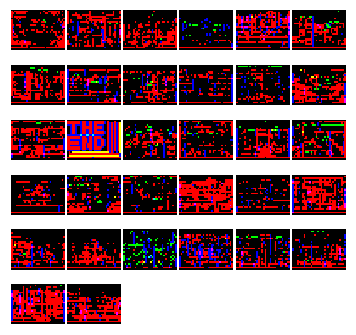

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.02642,
[0.15502958 0.46062632 0.27951176 0.22378421 0.16465696 0.08460704
 0.0751     0.36914762 0.44786119 0.24368974 0.23539412 1.0001
 0.66207183 0.04235352 0.28245294 0.42038986 0.41186471 0.24400244
 0.4751     0.17401304 0.12338767 0.22737273 0.27787778 0.10536316
 0.3165557  0.13803103 0.16676667 0.23819524 0.21528987 0.09269259
 0.02951176 0.02641579]
1 th evolution, score_max:1.0, score_min:0.07605,
[0.96062632 0.32317692 0.20248095 0.56726418 0.42867143 0.38898889
 0.41343333 0.35304118 0.21804872 0.41782152 1.0001     0.07604937
 0.24106386 0.11604203 0.3374494  1.0001     0.30347079 0.78215128
 0.94530548 0.25297356 0.48621111 0.7751     0.17657059 0.30676667
 0.21927808 0.58118108 0.19127647 0.34256575 0.31178831 0.10616061
 0.77429355 0.3751    ]


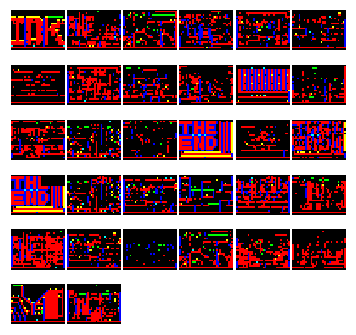

2 th evolution, score_max:1.0, score_min:0.2052,
[0.30347079 0.41583034 0.86496486 0.35626438 0.63865422 0.5876
 0.45293019 1.0001     0.40973855 0.76200476 0.88581429 0.20522821
 0.96885    0.31516849 0.54676667 0.7817092  0.30962381 0.27720843
 0.51734138 0.62328841 0.42867143 0.95724286 0.35830896 0.9001
 0.63167895 0.9501     0.4626     0.38366164 0.57313371 0.28135
 0.22545211 0.75651026]


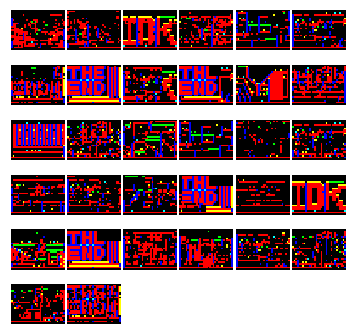

3 th evolution, score_max:1.0, score_min:0.2389,
[0.83833529 0.98898889 0.23890597 0.97343333 0.91186471 0.41548462
 0.359475   0.70248095 0.89562239 0.83793784 0.86914762 0.64112564
 0.97024925 0.85536316 0.40799474 0.38471538 0.44196047 0.49263731
 0.87650449 0.86966522 0.29421765 0.35074935 0.63646364 0.7201
 1.0001     0.4876     0.3601     0.57481264 0.84625385 0.55565556
 0.57327073 0.57152857]


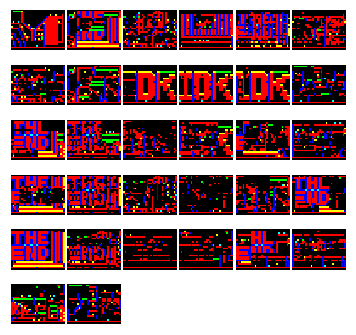

4 th evolution, score_max:1.0, score_min:0.2309,
[0.7201     0.86496486 0.38898889 0.89562239 0.30962381 0.94604595
 0.76066338 0.46763247 0.6001     0.86895246 0.79528072 0.42867143
 0.85375854 0.88742394 0.45724286 0.54127647 1.0001     0.23086923
 0.41901892 0.37152857 0.5001     0.60616061 0.96818511 0.65892353
 0.60536316 0.61774706 0.96113896 0.65227391 0.98494848 0.80908876
 0.73621111 0.2963963 ]


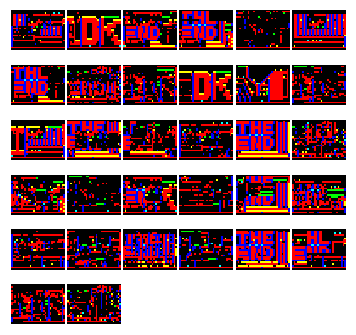

5 th evolution, score_max:1.0, score_min:0.19,
[0.7601     0.81828182 0.88471538 0.28777123 0.55082464 0.28099888
 0.52574103 0.54555455 0.98873636 0.98805181 0.89883418 0.36241884
 0.43488261 0.94604595 1.0001     0.90133457 0.51325789 0.18997342
 0.55233881 0.72982973 0.58833529 0.47836087 0.42867143 0.83880968
 0.71286596 0.92781084 0.58237848 0.98886404 0.60724286 0.81343333
 0.87152857 0.51200476]


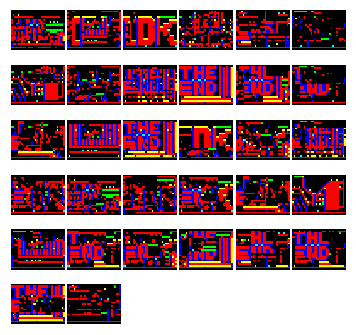

6 th evolution, score_max:1.0, score_min:0.2193,
[0.69057619 0.890725   0.73343333 0.79230779 0.88245294 0.45689012
 0.8116942  1.0001     0.53040303 0.97307297 0.7751     0.58451558
 0.96480588 0.68431053 0.95565556 0.89166627 0.4401     0.21927808
 1.0001     0.59046145 0.67083171 0.52122676 0.85925493 1.0001
 1.0001     0.82201781 0.73694211 0.56766757 0.82152857 0.83539412
 0.95304118 0.84941507]


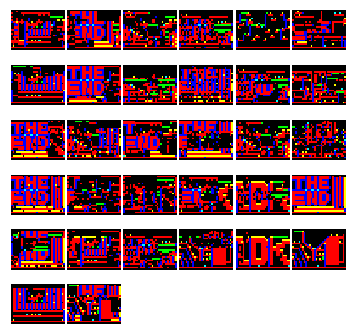

7 th evolution, score_max:1.0, score_min:0.4287,
[0.96113896 0.87847838 0.52282727 0.98833529 0.76281186 0.94212899
 0.95662174 0.62347662 0.76480588 0.95358837 0.59687419 0.88105238
 0.98790488 0.96784194 0.58984359 1.0001     0.55565556 0.90919091
 0.74708795 0.42867143 0.90227391 0.70741707 0.56766757 1.0001
 0.94881795 0.70598235 0.55415405 0.95071728 0.8631137  0.7376
 0.52574103 0.70676667]


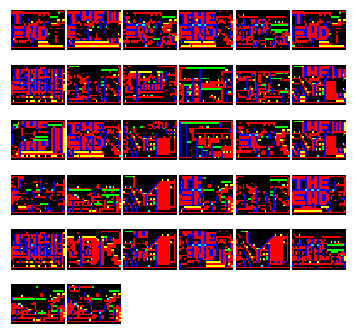

8 th evolution, score_max:1.0, score_min:0.1482,
[0.48694211 0.7033967  0.9876     0.8001     1.0001     0.95843333
 0.44786119 0.66676667 0.85403258 0.68302683 0.97478354 0.97378421
 0.94212899 0.95532388 0.65343333 0.97307297 0.90919091 1.0001
 0.63167895 0.46351463 0.95724286 0.57362941 0.92547313 0.82362941
 0.93488261 0.8001     0.14824815 0.32867143 0.86823187 0.96676667
 0.98711299 0.61828182]


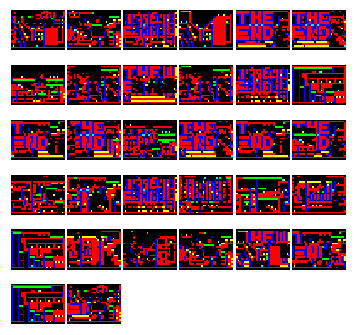

9 th evolution, score_max:1.0, score_min:0.4232,
[0.58471538 0.77641579 0.91559296 0.53633188 1.0001     0.88581429
 0.68841169 0.65070241 0.49216349 0.92867143 0.94604595 0.6401
 1.0001     0.82061282 0.94295714 0.92317692 1.0001     0.93558387
 0.98694211 0.93488261 0.89715882 1.0001     0.8029169  0.98711299
 0.42317692 0.96113896 0.67098608 0.96561724 0.90919091 0.98819524
 0.95248095 0.76200476]


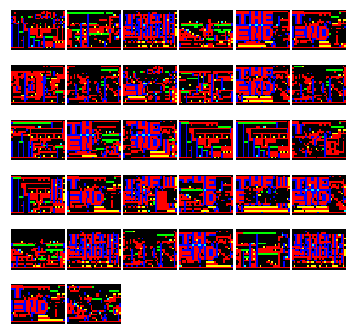

epoch: 0 ,conclusion
raw population


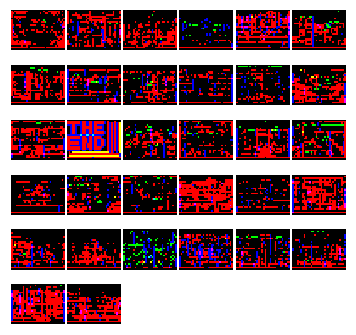

final image


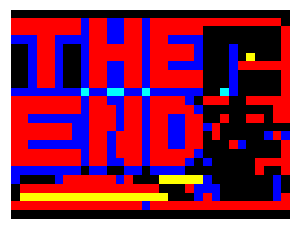

final population


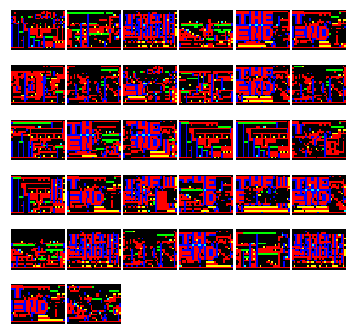

epoch: 1 ,start----------------------------------------------


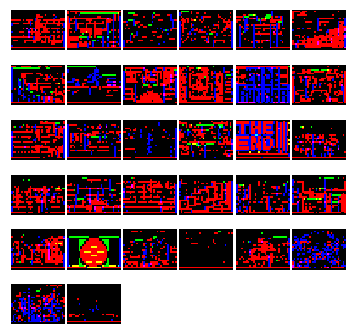

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.0001,
[9.03714458e-01 6.81259420e-01 4.82027711e-01 8.78478378e-01
 1.00010000e+00 1.73433333e-01 5.25100000e-01 1.86766667e-01
 5.28835632e-01 3.90904598e-01 8.25100000e-01 1.39340506e-01
 7.47268657e-02 7.36942105e-01 4.15684416e-01 8.11694203e-01
 5.14385714e-01 5.60100000e-01 9.86211111e-01 3.43383582e-01
 3.12600000e-01 2.00100000e-01 2.63988889e-01 1.89289189e-01
 3.85642169e-01 4.69750000e-02 1.44678313e-01 5.56555556e-02
 9.42176471e-02 1.64935165e-01 2.28671429e-01 1.00000000e-04]
1 th evolution, score_max:1.0, score_min:0.08056,
[0.74693544 1.0001     0.75372319 0.71804872 0.61774706 0.80529481
 0.47629048 1.0001     0.1501     0.92718333 0.84941507 0.6120403
 0.43488261 0.8751     0.34052553 0.38366164 0.28419091 0.81142075
 0.2963963  0.97111449 0.90814598 0.30565556 0.08055977 0.5001
 0.42475753 0.14295714 0.32152857 0.5001     0.41676667 0.84279663
 0.39516173 0.14824815]


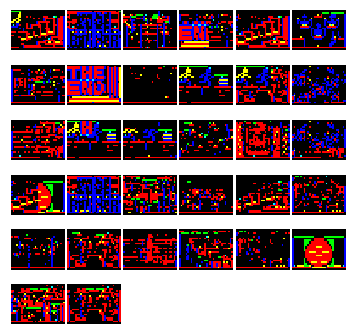

2 th evolution, score_max:1.0, score_min:0.1539,
[0.98744177 0.26146364 0.8878551  0.53942584 0.2184908  0.72473768
 0.69145802 1.0001     0.79555455 0.83571644 0.63898889 0.50642911
 0.63646364 0.86852105 0.15394615 1.0001     0.9876     0.74295714
 0.38038169 0.79176667 0.41121111 0.27037027 1.0001     0.89295714
 0.57362941 0.85343333 0.87333944 0.92951176 0.77787778 0.28898889
 0.32442432 0.38038169]


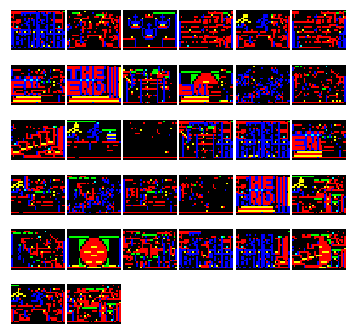

3 th evolution, score_max:1.0, score_min:0.1359,
[0.91368025 0.86676667 0.97989798 0.94530548 0.84732222 0.47897324
 0.91813279 0.83343333 0.40550541 0.95532388 0.77474789 0.67577568
 1.0001     0.13590247 0.13646364 0.67083171 0.70522821 1.0001
 0.96113896 0.38245294 0.45955946 0.85892353 0.58237848 0.70796517
 0.87702308 0.53741343 0.92217792 0.97570976 0.27546232 0.44454444
 0.59503671 0.39715882]


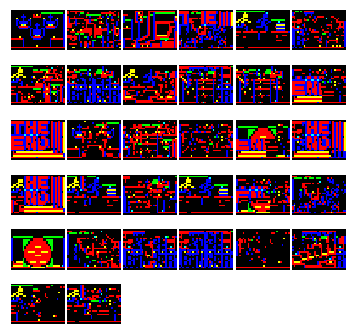

4 th evolution, score_max:1.0, score_min:0.3078,
[0.94127647 0.76754186 0.41568442 0.6026641  0.85195185 0.84820127
 0.60304118 0.69454444 0.70676667 0.94946709 0.9517129  0.30779231
 0.69889518 0.46676667 0.96306296 0.95358837 0.7817092  0.7751
 0.88617595 0.98658649 0.98676667 0.83108592 0.84295714 0.88898889
 0.94454444 0.92317692 0.86526854 1.0001     0.61914762 0.87961807
 0.97737273 0.66676667]


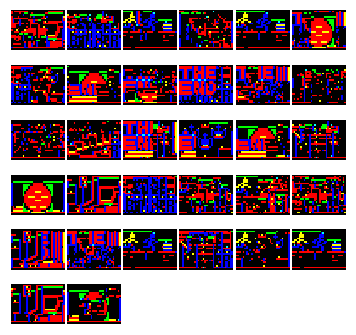

5 th evolution, score_max:1.0, score_min:0.2626,
[0.61121111 0.81828182 0.85724286 0.6836443  0.82061282 0.96212532
 0.81022658 0.83108592 0.2626     0.93431053 0.81531739 0.91186471
 1.0001     0.8631137  0.80831918 0.85403258 1.0001     0.92415063
 0.88898889 0.88742394 0.44652857 0.91473415 0.60769494 0.96521628
 0.7196122  0.6836443  0.70222766 0.9201     1.0001     0.64945065
 0.9626     0.91035641]


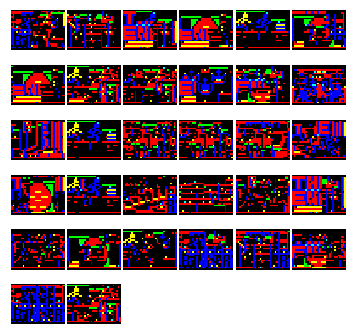

6 th evolution, score_max:1.0, score_min:0.2908,
[0.54771905 0.82726049 0.47955205 0.87888788 0.78135    0.87378421
 0.81954444 0.88167895 0.48245294 0.84625385 1.0001     0.88415797
 0.89199189 0.29079767 0.83343333 0.68898889 0.94212899 0.84517042
 1.0001     0.81588947 0.76754186 0.53773441 0.91676667 0.93268427
 0.90707674 0.80908876 0.76633377 0.98790488 0.74613175 0.44313797
 0.97570976 0.29343333]


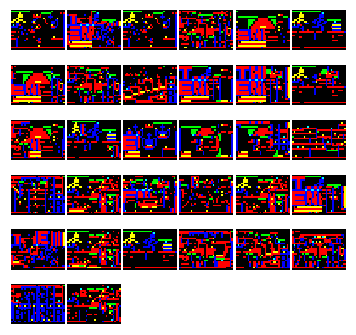

7 th evolution, score_max:1.0, score_min:0.2001,
[1.0001     0.90598235 0.91964023 0.5061241  0.72161899 0.74693544
 0.81717317 0.7762194  0.98370656 0.82099552 0.84715882 0.85536316
 0.91438571 0.92867143 0.72068824 1.0001     0.89051096 0.57152857
 0.71438571 0.6836443  0.2001     0.88105238 0.78092192 0.41901892
 0.83960617 0.90919091 0.97152857 1.0001     0.89865072 0.92967746
 0.98860575 0.87814878]


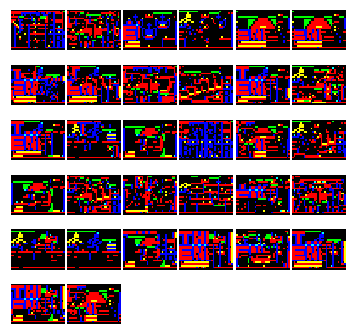

8 th evolution, score_max:1.0, score_min:0.5947,
[0.8975359  0.76129403 0.86085949 0.97629048 0.65799474 0.7973973
 0.92967746 0.92115263 1.0001     0.98727949 0.98833529 0.94328182
 0.59469459 0.82904737 0.86373636 0.96521628 0.65527241 0.9601
 0.8373093  0.89257312 0.8751     0.90133457 0.84295714 0.71920112
 0.66676667 0.88617595 0.90676667 0.79756835 0.89483684 1.0001
 0.67911235 0.83343333]


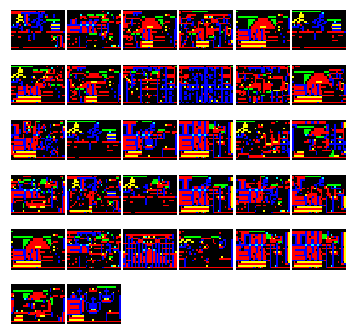

9 th evolution, score_max:1.0, score_min:0.4639,
[0.97152857 0.86429753 0.85552169 0.91676667 0.9517129  0.9251
 0.97570976 0.88742394 0.7722519  0.62830513 0.94530548 0.6026641
 0.98494848 0.98744177 0.92602593 1.0001     0.84792609 0.82618696
 0.83343333 0.69630253 0.80242558 0.97343333 0.97378421 0.76821594
 0.73503976 0.97711149 0.96480588 0.82115263 0.97378421 0.46386812
 0.94057619 0.86085949]


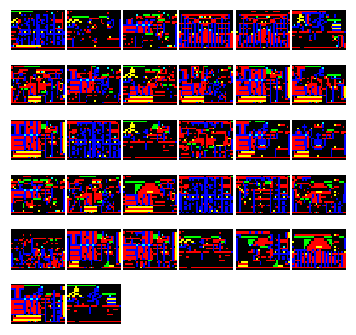

epoch: 1 ,conclusion
raw population


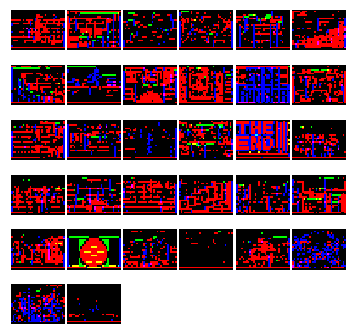

final image


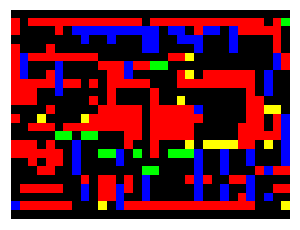

final population


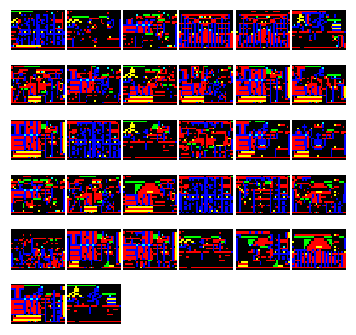

epoch: 2 ,start----------------------------------------------


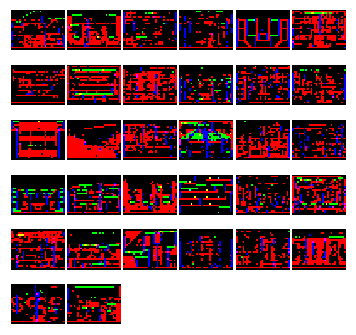

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.01525,
[1.0001     0.40239885 1.0001     0.44454444 0.11950299 0.14127647
 0.48898889 0.38676667 0.42676667 0.90635    0.14467831 0.12867143
 0.97737273 0.20905522 0.01525152 0.58740159 0.19454444 0.02449024
 0.38471538 0.37984684 0.49377089 0.10136582 0.13424634 0.35830896
 0.0751     0.15863659 0.25651026 0.10853373 0.17577568 0.11774706
 0.04928033 0.05489452]
1 th evolution, score_max:1.0, score_min:0.04064,
[0.98775432 0.13263012 0.10724286 0.16991132 0.41583034 0.8989764
 0.48061948 1.0001     0.77152857 0.38038169 0.83793784 0.07702308
 0.21528987 0.64715882 0.52818989 0.54064054 0.41186471 0.04064054
 0.59469459 0.70940233 0.54421765 0.30892353 0.16465696 0.63865422
 0.41985309 0.50714225 0.13523514 0.13569322 0.37672338 0.32886712
 1.0001     0.06676667]


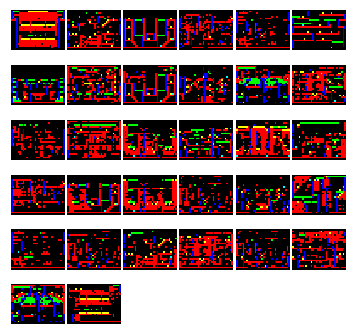

2 th evolution, score_max:1.0, score_min:0.09101,
[0.91762577 0.5001     0.40287778 0.35174835 0.72473768 0.42475753
 0.5376     0.72849506 0.31516849 0.96600909 0.39782727 0.26446782
 0.6126     0.88742394 0.7126     0.30565556 0.25343333 0.44588313
 0.41343333 0.68125942 0.2401     0.88898889 0.5001     0.6628907
 0.37657059 1.0001     0.45464545 0.20491928 0.36996301 0.09100909
 0.6751     0.53434658]


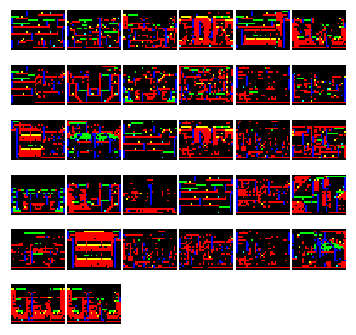

3 th evolution, score_max:1.0, score_min:0.1464,
[0.90371446 0.59220526 0.78833529 0.70522821 0.22737273 0.55892353
 0.33343333 0.98805181 0.72068824 0.26770563 0.58898889 0.74084074
 0.61048961 0.30995915 1.0001     0.26425094 1.0001     0.4751
 0.3501     0.28957368 0.48658649 0.47201011 0.35221268 0.9376
 0.14644146 0.3751     0.49285362 0.57387049 0.67152857 0.2963963
 0.32921392 0.6032746 ]


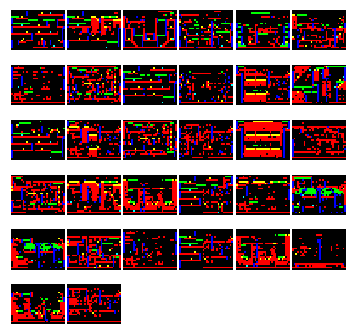

4 th evolution, score_max:1.0, score_min:0.2569,
[0.96113896 0.77118434 0.51325789 0.86373636 0.56480588 0.51734138
 0.73503976 0.67068824 0.75372319 0.84625385 0.37691159 1.0001
 0.40239885 0.9048619  0.71774706 0.97270274 0.73982603 0.79797234
 0.81588947 0.6126     0.3751     0.32061282 0.55565556 0.25685676
 0.4058971  0.86216897 0.5751     0.71274368 0.27546232 0.55799474
 0.4801     0.91676667]


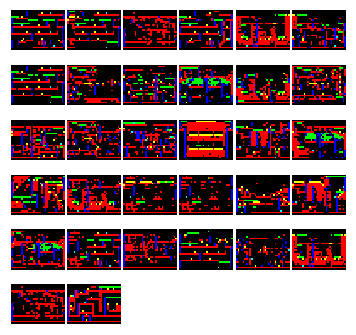

5 th evolution, score_max:0.9866, score_min:0.2425,
[0.52867143 0.44454444 0.86966522 0.98517463 0.37372637 0.765725
 0.86676667 0.7722519  0.48694211 0.70522821 0.84517042 0.82061282
 0.47836087 0.76722329 0.80962381 0.95515618 0.71024493 0.8001
 0.45464545 0.28925663 0.24252424 0.71600909 0.82936829 0.46763247
 0.98658649 0.27152857 0.32362941 0.6985127  0.8001     0.76129403
 0.6836443  0.73249437]


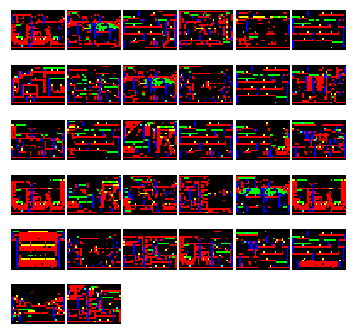

6 th evolution, score_max:1.0, score_min:0.2661,
[0.70843333 0.30389747 0.74035974 0.80861064 0.5001     0.82726049
 0.26605745 0.74035974 0.76480588 0.64377816 0.64798732 0.7973973
 0.74334324 1.0001     0.64798732 0.84858485 0.9376     0.46676667
 0.98422698 0.75619756 0.36480588 0.38676667 0.53235806 0.73873636
 0.74428605 0.56107561 0.8001     0.82442432 0.56986744 0.89782727
 0.7601     0.38719677]


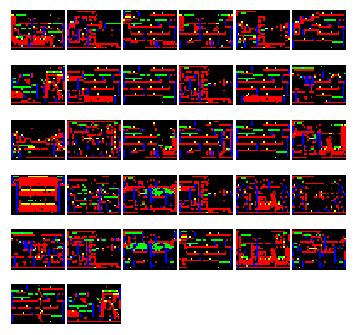

7 th evolution, score_max:0.9871, score_min:0.3693,
[0.36933077 0.98711299 0.40287778 0.70662174 0.703225   0.79528072
 0.73265814 0.77787778 0.57362941 0.64207531 0.65763425 0.8376
 0.67068824 0.96306296 0.57313371 0.77787778 0.61548462 0.70896076
 0.98494848 0.72537473 0.4251     0.80444783 0.7722519  0.59469459
 0.8751     0.56954444 0.7501     0.97378421 0.79756835 0.61774706
 0.56726418 0.84220526]


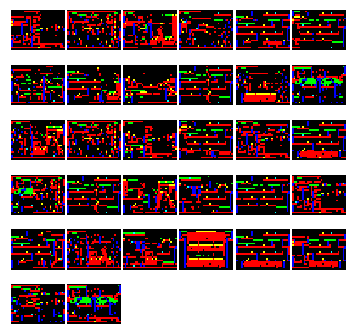

8 th evolution, score_max:1.0, score_min:0.04296,
[0.74657887 0.54888049 0.86496486 0.60475116 0.90332581 0.04295714
 0.73265814 0.56107561 0.7827087  1.0001     0.71614938 0.60820811
 0.33343333 0.96713297 0.57544247 0.80256914 0.48727949 0.93113448
 0.71840986 0.85724286 1.0001     0.73249437 0.70432535 0.59560562
 1.0001     0.54176667 0.78957368 0.7028027  0.95304118 0.69240769
 0.8314253  0.61121111]


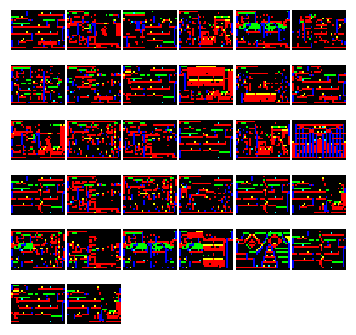

9 th evolution, score_max:0.9871, score_min:0.4445,
[0.8376     0.7722519  0.98711299 0.48790488 0.76633377 0.98581429
 0.98494848 0.57904737 0.62972963 0.64295714 0.58251758 0.87961807
 0.75913614 0.77787778 0.74084074 0.56766757 0.54330988 0.6376
 0.68928919 0.68928919 0.63646364 0.59711493 0.72737273 0.79462055
 0.83343333 0.67615634 0.66676667 0.93680886 0.69240769 0.55892353
 0.95955946 0.44454444]


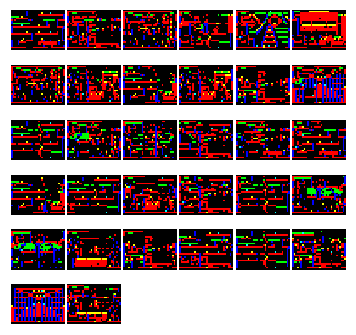

epoch: 2 ,conclusion
raw population


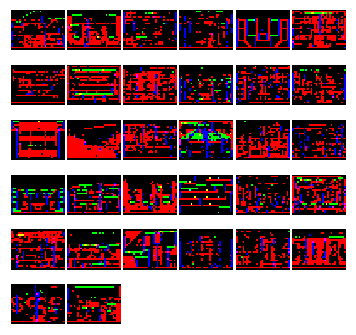

final image


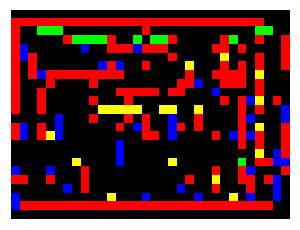

final population


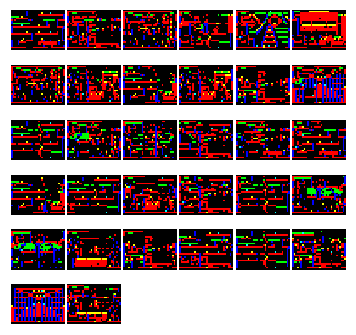

epoch: 3 ,start----------------------------------------------


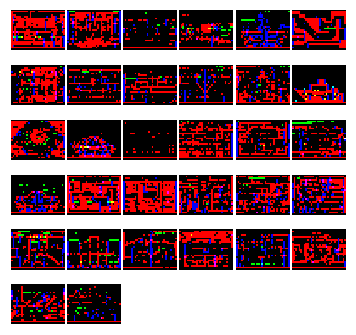

(10000, 24, 32, 5)
0 th evolution, score_max:0.8445, score_min:0.05566,
[0.50734638 0.21631622 0.69328182 0.41901892 0.37152857 0.84454444
 0.45358837 0.06070606 0.2376     0.39736027 0.8031303  0.4751
 0.10968904 0.67751935 0.33776234 0.18319859 0.34676667 0.52818989
 0.65227391 0.5916493  0.78092192 0.07152857 0.31954444 0.47068824
 0.17115263 0.27037027 0.07068824 0.1548619  0.234475   0.05565556
 0.07875169 0.05724286]
1 th evolution, score_max:0.9013, score_min:0.1027,
[0.90133457 0.8751     0.31894058 0.26770563 0.28925663 0.1026641
 0.71438571 0.5943029  0.40750741 0.12172162 0.6001     0.59100909
 0.20440108 0.65070241 0.53256753 0.81828182 0.22115263 0.66676667
 0.30779231 0.2501     0.25619756 0.4517129  0.50676667 0.859475
 0.57756479 0.72867143 0.28581429 0.35830896 0.63646364 0.21600909
 0.21438571 0.61186471]


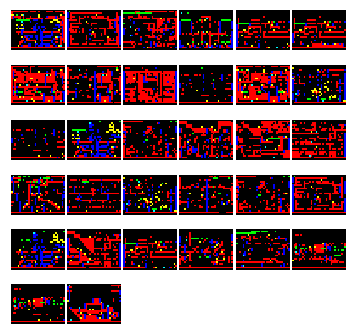

2 th evolution, score_max:0.9376, score_min:0.07605,
[0.9376     0.8001     0.56348028 0.27390952 0.62205122 0.6548619
 0.27951176 0.36154578 0.47152857 0.29518197 0.24060633 0.33793784
 0.5916493  0.45358837 0.62328841 0.22232222 0.84625385 0.22350426
 0.59711493 0.8022978  0.21885    0.20248095 0.76398889 0.69024085
 0.72378421 0.25767576 0.16676667 0.85925493 0.07604937 0.5001
 0.36241884 0.5863069 ]


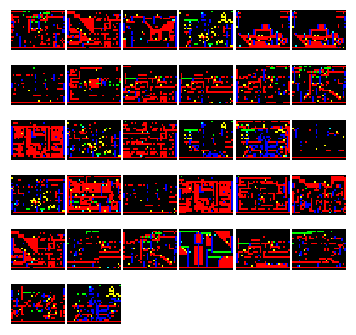

3 th evolution, score_max:0.9488, score_min:0.143,
[0.14295714 0.49305775 0.75318642 0.6001     0.79278293 0.94881795
 0.76839268 0.3251     0.51438571 0.81619195 0.87068824 0.60503827
 0.8376     0.7001     0.55082464 0.81700141 0.62800698 0.25343333
 0.87068824 0.5863069  0.24203548 0.24685325 0.28957368 0.16226216
 0.23297671 0.81700141 0.60503827 0.71885    0.25816452 0.18319859
 0.3016873  0.18528519]


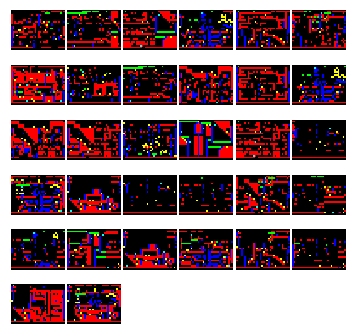

4 th evolution, score_max:0.9426, score_min:0.1317,
[0.13343333 0.61438571 0.21804872 0.73539412 0.92415063 0.48061948
 0.2501     0.57544247 0.2346679  0.57544247 0.79375079 0.54330988
 0.84347349 0.22737273 0.44454444 0.7196122  0.74084074 0.83126883
 0.77641579 0.13167895 0.21121111 0.28099888 0.90707674 0.26770563
 0.35304118 0.70248095 0.69145802 0.58740159 0.94262874 0.56954444
 0.7196122  0.72737273]


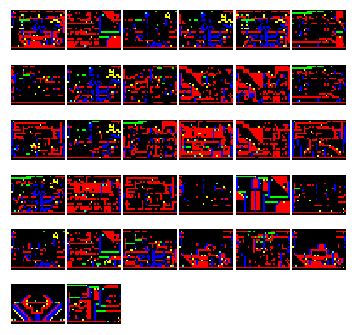

5 th evolution, score_max:0.8914, score_min:0.1689,
[0.7501     0.72473768 0.64207531 0.7376     0.17401304 0.6251
 0.71804872 0.68841169 0.67751935 0.74676667 0.73265814 0.61373636
 0.16893117 0.59687419 0.55394615 0.38038169 0.30444783 0.87311587
 0.65227391 0.78957368 0.86595366 0.64945065 0.75913614 0.79756835
 0.89140435 0.47307297 0.49392716 0.61914762 0.77787778 0.43383494
 0.67282727 0.64112564]


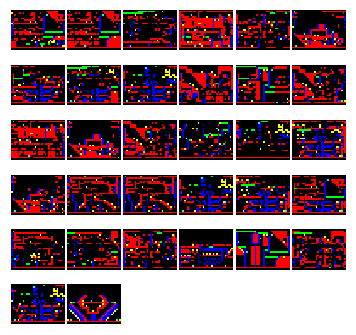

6 th evolution, score_max:0.8838, score_min:0.3495,
[0.55747705 0.71438571 0.39715882 0.74295714 0.59584468 0.7028027
 0.62830513 0.5001     0.62676667 0.42178675 0.69024085 0.56933077
 0.87664321 0.62972963 0.39769036 0.88382093 0.5001     0.7201
 0.81954444 0.50676667 0.5891411  0.77932078 0.34949759 0.68841169
 0.65442099 0.6751     0.54555455 0.63523514 0.49285362 0.60724286
 0.5001     0.5001    ]


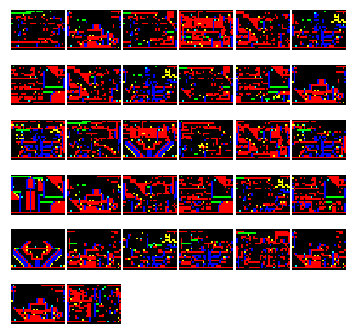

7 th evolution, score_max:0.8903, score_min:0.3764,
[0.78581429 0.45689012 0.83960617 0.5001     0.53668537 0.38366164
 0.71804872 0.61774706 0.5309642  0.77916977 0.40750741 0.71804872
 0.37644409 0.62232222 0.63424634 0.6836443  0.76480588 0.70896076
 0.74586271 0.69421765 0.72378421 0.83343333 0.7655321  0.43488261
 0.4751     0.56972025 0.53668537 0.49360649 0.61637907 0.8903439
 0.57152857 0.61048961]


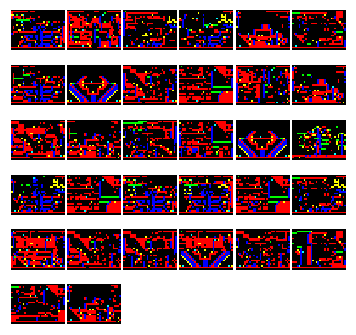

8 th evolution, score_max:0.8903, score_min:0.2467,
[0.38366164 0.65666566 0.71631622 0.4376     0.78215128 0.53531127
 0.61914762 0.69421765 0.67083171 0.46845443 0.63424634 0.8903439
 0.5309642  0.65944066 0.66314348 0.79771905 0.6401     0.72737273
 0.61048961 0.63167895 0.58938571 0.81700141 0.72317692 0.66676667
 0.62800698 0.24667534 0.43671972 0.67152857 0.7196122  0.62172162
 0.8126     0.71274368]


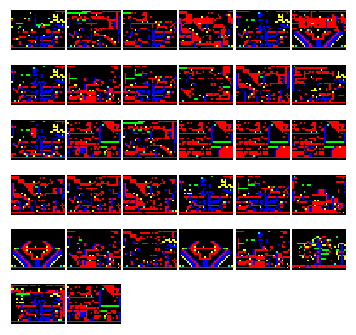

9 th evolution, score_max:0.8796, score_min:0.1001,
[0.64715882 0.46585342 0.82201781 0.86852105 0.64295714 0.64207531
 0.67115263 0.24368974 0.69454444 0.65763425 0.23953662 0.53343333
 0.3975359  0.65161515 0.58676667 0.56588947 0.84517042 0.70248095
 0.87961807 0.1001     0.68302683 0.67867143 0.73856154 0.7251
 0.63424634 0.6251     0.71196441 0.7028027  0.51438571 0.71438571
 0.70464545 0.69873014]


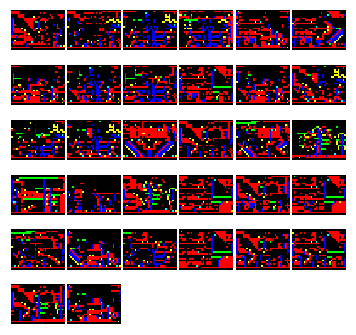

epoch: 3 ,conclusion
raw population


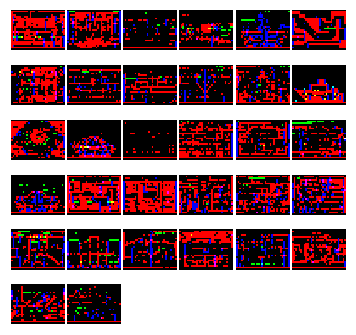

final image


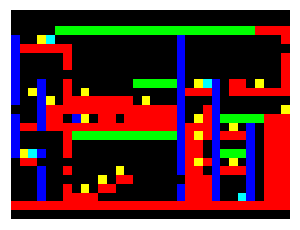

final population


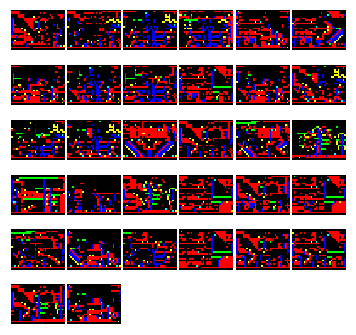

epoch: 4 ,start----------------------------------------------


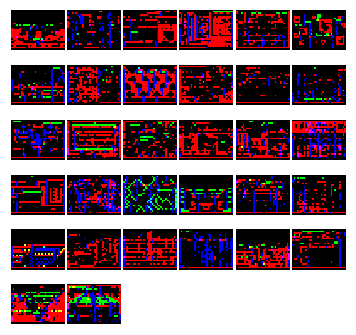

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.02677,
[0.51958052 0.08705652 0.28925663 0.1876     0.98694211 0.05138205
 1.0001     0.515725   0.38471538 0.94196047 0.43539412 0.41473415
 0.93253243 0.43065556 0.86429753 0.40308507 0.25619756 0.21631622
 0.25343333 0.12830513 0.59312326 0.70159254 0.19454444 0.078225
 0.36121111 0.19127647 0.02676667 0.03906104 0.08443735 0.03624458
 0.12078966 0.07585758]
1 th evolution, score_max:0.9879, score_min:0.02607,
[0.02607403 0.21927808 0.41438571 0.42317692 0.64295714 0.0801
 0.62676667 0.88053478 0.32886712 0.90550541 0.83705652 0.09687419
 0.16373636 0.03807468 0.28797879 0.93416593 0.09599041 0.98790488
 0.13856154 0.45273158 0.7013987  0.4501     0.74368974 0.23265814
 0.32921392 0.43343333 0.60475116 0.26592278 0.28925663 0.47378421
 0.2174913  0.63898889]


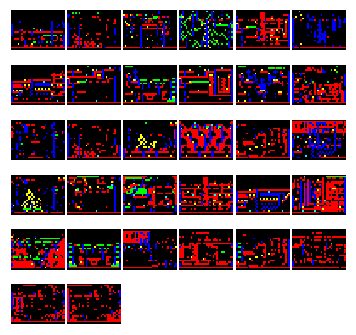

2 th evolution, score_max:1.0, score_min:0.1048,
[0.51658352 0.23694211 1.0001     0.23539412 0.34187215 0.13053478
 0.10475116 0.3944662  0.30497805 0.89421765 0.70896076 0.75685676
 0.69672921 0.58034691 0.46585342 0.35965056 0.30444783 0.2740726
 0.57313371 0.32845821 0.86373636 0.94039851 0.12205122 0.1642791
 0.5601     0.63167895 0.37047037 0.44604595 0.43912439 0.4951495
 0.6120403  0.24185824]


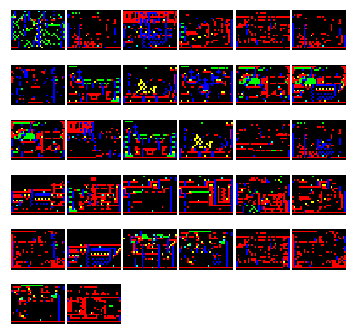

3 th evolution, score_max:0.9868, score_min:0.07153,
[0.62660602 0.66243766 0.8751     0.22982973 0.84454444 0.34492759
 0.67115263 0.96620169 0.4058971  0.828225   0.85536316 0.49263731
 0.3909046  0.56954444 0.79357826 0.55565556 0.32108765 0.32618696
 0.54176667 0.91054776 0.98676667 0.46763247 0.93160685 0.33343333
 0.43558387 0.25852697 0.7501     0.26839268 0.29343333 0.07152857
 0.34625385 0.50734638]


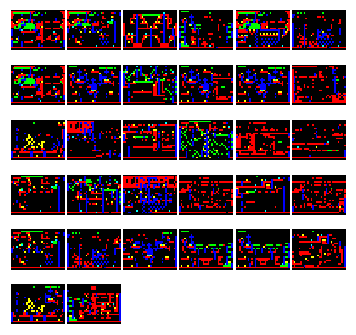

4 th evolution, score_max:0.9892, score_min:0.1766,
[0.86914762 0.51861852 0.37088652 0.17657059 0.72161899 0.20843333
 0.67615634 0.38281605 0.20557945 0.41035641 0.83880968 0.61828182
 0.74676667 0.38898889 0.2184908  0.6836443  0.98923043 0.51325789
 0.70843333 0.48581429 0.88415797 0.58343333 0.7501     0.57152857
 0.79720145 0.2001     0.81405349 0.78957368 0.859475   0.5876
 0.64782727 0.38167895]


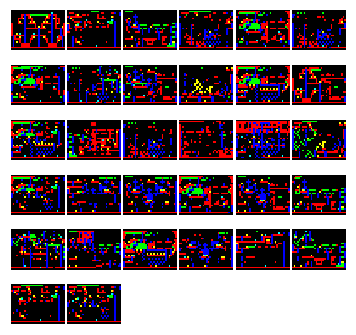

5 th evolution, score_max:1.0, score_min:0.244,
[0.57343333 0.77118434 0.53256753 0.6836443  0.26096957 0.92434242
 0.60475116 0.47152857 1.0001     0.86373636 0.81828182 0.66207183
 0.85552169 0.61455783 0.31121111 0.86774706 0.86676667 0.59503671
 0.57904737 0.47897324 0.51325789 0.57981014 0.24400244 0.5001
 0.74735275 0.48202771 0.25311205 0.87787778 0.70248095 0.3751
 0.26933077 0.81091081]


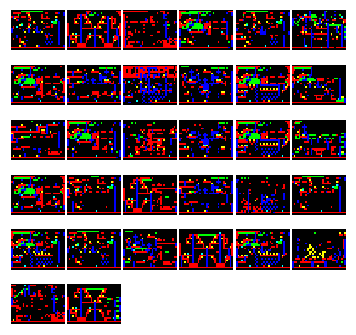

6 th evolution, score_max:1.0, score_min:0.2259,
[0.80256914 0.82362941 0.8126     0.77787778 0.7762194  0.62830513
 0.58984359 0.85237273 0.25935926 0.23890597 0.37219302 0.67083171
 0.34075934 1.0001     0.8401     0.68245294 0.57585758 0.59312326
 0.98744177 0.67133288 0.81828182 0.61121111 0.57152857 0.68302683
 0.78676667 0.49325068 0.51774706 0.51676667 0.47897324 0.22590645
 0.7601     0.88742394]


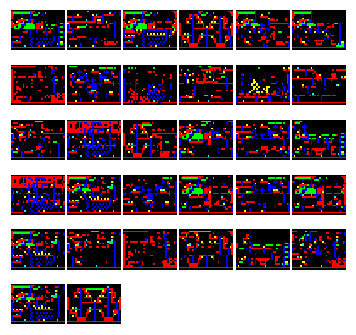

7 th evolution, score_max:1.0, score_min:0.2652,
[0.83156067 0.72103023 0.7762194  0.33812817 0.90598235 0.81186471
 0.7876     0.90919091 0.92951176 0.40707674 0.73982603 0.8962039
 0.60536316 0.44881795 0.59469459 0.82867143 0.40253902 0.5601
 0.26516024 0.609475   0.72473768 1.0001     1.0001     0.55082464
 0.81091081 0.67133288 0.44604595 0.47897324 0.5751     0.50584713
 0.34385    0.90253902]


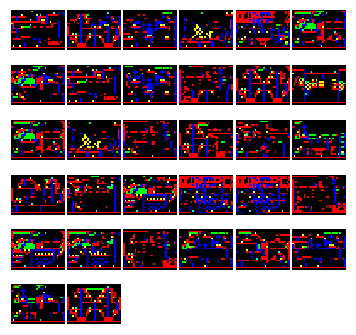

8 th evolution, score_max:1.0, score_min:0.1782,
[0.97343333 0.61373636 0.91870465 0.50803651 0.81044483 0.81954444
 0.42676667 0.78581429 0.8376     0.88069701 0.79785281 0.66139032
 0.88471538 0.4626     1.0001     0.85925493 0.5001     0.30389747
 0.85145135 0.5001     0.93516494 0.6126     0.71286596 0.7501
 0.8001     0.69630253 0.73694211 0.64566962 0.88167895 0.74636866
 0.17818219 0.48658649]


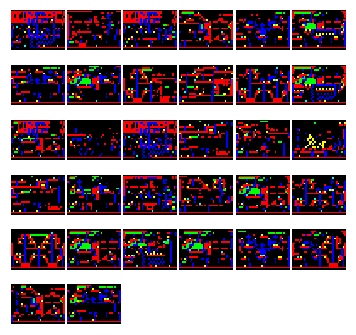

9 th evolution, score_max:1.0, score_min:0.2536,
[0.98727949 0.7261274  0.54676667 1.0001     0.75619756 0.87787778
 0.74400244 0.5626     0.89199189 0.8314253  0.86595366 0.93516494
 0.79375079 0.30389747 0.60769494 0.76933077 0.65394615 0.69873014
 0.54330988 0.30444783 0.69454444 0.81828182 0.47068824 0.86774706
 0.86852105 0.89421765 0.66676667 0.25362113 0.63778116 0.42867143
 0.56348028 0.68065556]


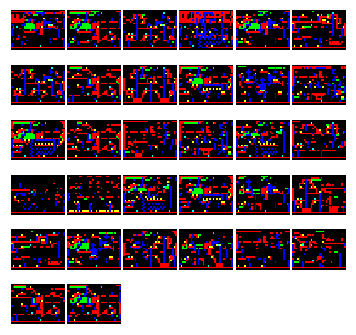

epoch: 4 ,conclusion
raw population


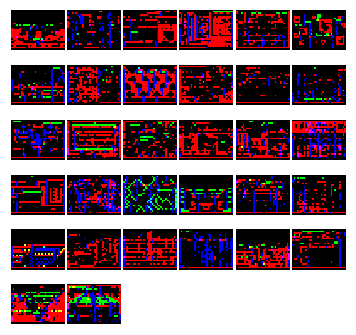

final image


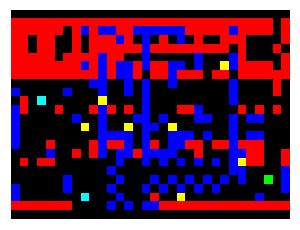

final population


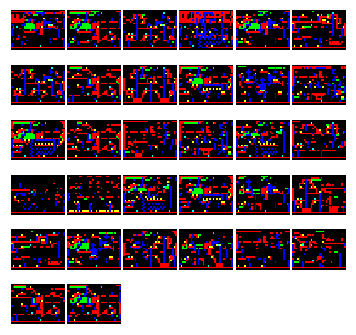

epoch: 5 ,start----------------------------------------------


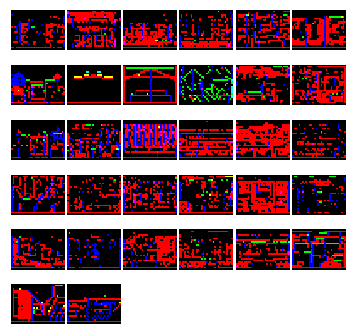

(10000, 24, 32, 5)
0 th evolution, score_max:0.9899, score_min:0.0138,
[0.82201781 0.3031303  0.49285362 0.88431053 0.79079767 0.67958718
 0.40993607 0.98989592 0.32904737 0.10598235 0.96113896 0.32442432
 0.60283973 0.31516849 0.73086923 0.39715882 0.41081429 0.30676667
 0.0801     0.19522195 0.30676667 0.40973855 0.09469459 0.12172162
 0.16139032 0.21548462 0.12997013 0.17401304 0.15287778 0.07327073
 0.03856154 0.01379863]
1 th evolution, score_max:0.989, score_min:0.08581,
[0.3751     0.7033967  0.74735275 0.19364839 0.83833529 0.34676667
 0.65343333 0.96561724 0.55233881 0.13196813 0.96163846 0.45358837
 0.98898889 0.29771905 0.68065556 0.93431053 0.33343333 0.70501803
 0.69364839 0.29176667 0.33343333 0.84156341 0.70598235 0.9376
 0.08581429 0.2174913  0.20598235 0.22836087 0.18191818 0.2174913
 0.46062632 0.16448356]


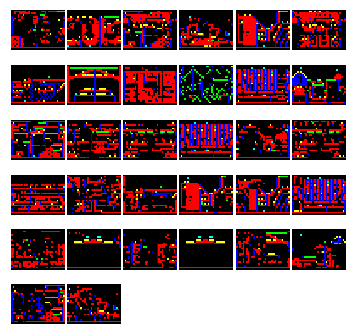

2 th evolution, score_max:0.9882, score_min:0.1643,
[0.1642791  0.67657059 0.93230339 0.72103023 0.87814878 0.65724286
 0.98819524 0.91790822 0.93912439 0.81954444 0.66676667 0.9601
 0.91149241 0.24701358 0.82676667 0.87847838 0.67615634 0.484475
 0.56174384 0.87814878 0.91676667 0.33343333 0.76722329 0.43599744
 0.93516494 0.19490519 0.45248095 0.70662174 0.40973855 0.74334324
 0.65944066 0.7827087 ]


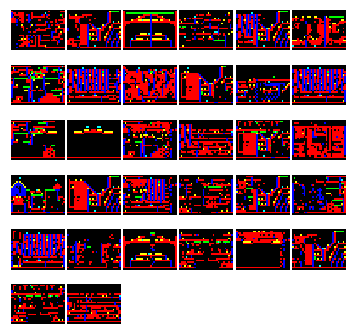

3 th evolution, score_max:0.9741, score_min:0.2382,
[0.67615634 0.796975   0.94604595 0.9138931  0.23819524 0.45793133
 0.88321688 0.47570976 0.43293582 0.8126     0.2501     0.74035974
 0.93033256 0.84425584 0.96835397 0.69328182 0.97152857 0.76933077
 0.58251758 0.95784648 0.80242558 0.5001     0.67615634 0.41568442
 0.75685676 0.5001     0.47897324 0.88382093 0.88581429 0.97412597
 0.77916977 0.5376    ]


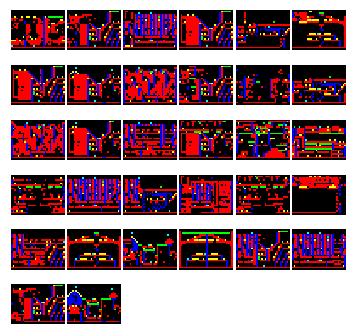

4 th evolution, score_max:0.9887, score_min:0.2274,
[0.98873636 0.74636866 0.9501     0.81343333 0.64798732 0.95071728
 0.68191818 0.81717317 0.77916977 0.92692927 0.94376197 0.68302683
 0.94127647 0.7805878  0.68581429 0.94530548 0.81343333 0.22737273
 0.5953381  0.32936829 0.9517129  0.71438571 0.81700141 0.92763623
 0.93912439 0.5001     0.29555455 0.26516024 0.90550541 0.87814878
 0.64207531 0.98833529]


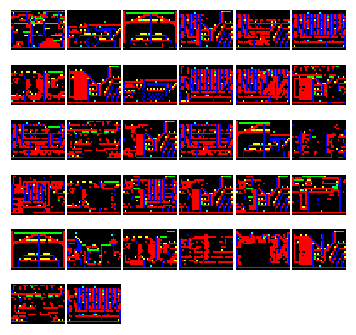

5 th evolution, score_max:0.9868, score_min:0.3078,
[0.90287778 0.80565556 0.94946709 0.95900411 0.89883418 0.30779231
 0.6251     0.95598235 0.48694211 0.62328841 0.78135    0.71804872
 0.89051096 0.6751     0.73180732 0.96395542 0.87152857 0.53856154
 0.88471538 0.98560725 0.83960617 0.96062632 0.8116942  0.95190723
 0.93558387 0.6780661  0.59269259 0.98676667 0.6548619  0.76933077
 0.90332581 0.6401    ]


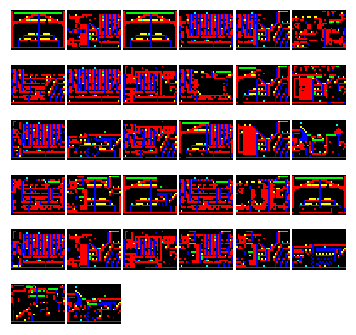

6 th evolution, score_max:0.9727, score_min:0.5073,
[0.81717317 0.9626     0.86676667 0.91576265 0.94530548 0.85273158
 0.97270274 0.87681233 0.87152857 0.56189775 0.62676667 0.8314253
 0.90919091 0.96600909 0.94815195 0.90287778 0.66676667 0.83833529
 0.8251     0.7762194  0.9376     0.95248095 0.70522821 0.92967746
 0.95190723 0.78215128 0.50734638 0.73265814 0.89199189 0.66226216
 0.88182043 0.76480588]


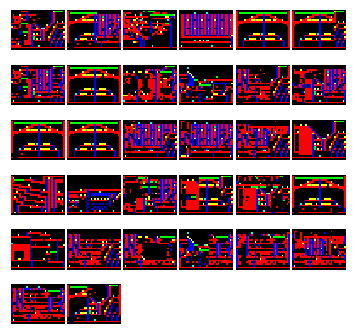

7 th evolution, score_max:0.9866, score_min:0.5754,
[0.75651026 0.76129403 0.76200476 0.94196047 0.71062632 0.98658649
 0.91186471 0.96062632 0.92763623 0.83126883 0.97570976 0.64958454
 0.84732222 0.57544247 0.76129403 0.91149241 0.93558387 0.89199189
 0.97307297 0.9001     0.58074516 0.91314348 0.74657887 0.94676667
 0.90133457 0.73343333 0.9201     0.60769494 0.82061282 0.94328182
 0.60475116 0.82676667]


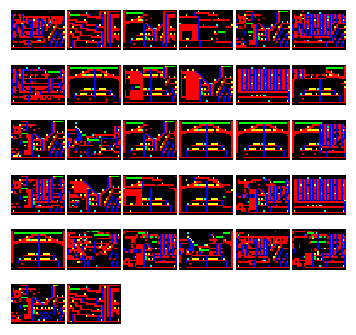

8 th evolution, score_max:0.9882, score_min:0.4659,
[0.91813279 0.94039851 0.71438571 0.83126883 0.98819524 0.56107561
 0.46585342 0.77152857 0.73982603 0.96979697 0.8962039  0.90779231
 0.85925493 0.96784194 0.765725   0.98560725 0.69127647 0.90371446
 0.82618696 0.84941507 0.89166627 0.92317692 0.94376197 0.78698525
 0.67826092 0.67577568 0.8001     0.57618696 0.95464545 0.86774706
 0.93912439 0.54771905]


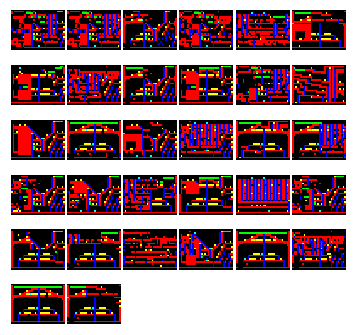

9 th evolution, score_max:0.9738, score_min:0.456,
[0.45598235 0.86373636 0.90287778 0.93599744 0.94127647 0.92144831
 0.82442432 0.7174913  0.95190723 0.70598235 0.78957368 0.88669794
 0.8359209  0.92867143 0.81828182 0.96306296 0.97152857 0.6001
 0.83343333 0.9601     0.85925493 0.91473415 0.87366322 0.90371446
 0.9601     0.96561724 0.71438571 0.97378421 0.84220526 0.85724286
 0.95662174 0.68302683]


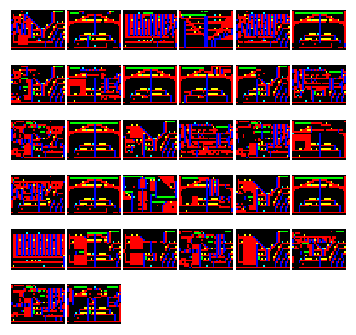

epoch: 5 ,conclusion
raw population


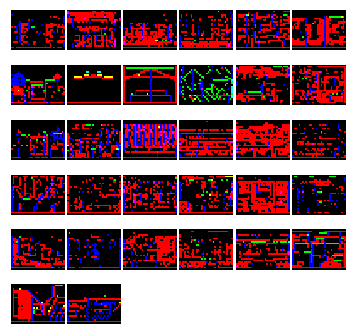

final image


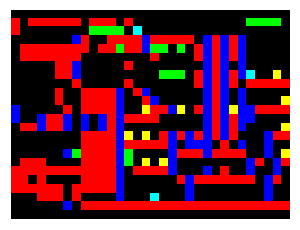

final population


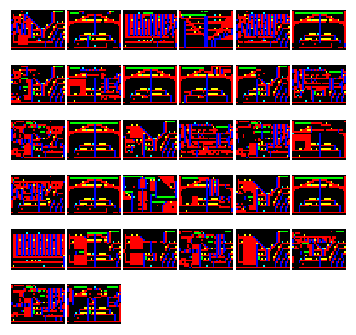

epoch: 6 ,start----------------------------------------------


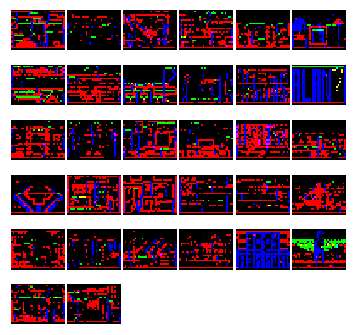

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.02909,
[0.96600909 0.32964545 0.87152857 1.0001     0.4001     0.63086923
 0.54555455 0.86852105 0.71939825 0.60250964 0.22867143 0.56348028
 0.77474789 0.5626     0.13442836 0.06954444 0.64295714 0.96979697
 0.21528987 0.40919091 0.10853373 0.03668537 0.29555455 0.23953662
 0.13523514 0.0801     0.07256377 0.61548462 0.05415405 0.12172162
 0.06676667 0.02908551]
1 th evolution, score_max:1.0, score_min:0.03807,
[0.55182414 0.98775432 0.32108765 0.24334324 0.6126     0.94746842
 0.03807468 0.7261274  0.96306296 0.65799474 0.5001     0.51525152
 0.57544247 0.64798732 0.84792609 0.58676667 0.79278293 0.2126
 0.18997342 0.22378421 1.0001     0.4801     0.24685325 0.28179014
 0.40973855 0.54888049 0.89225686 0.234475   0.17293951 0.43671972
 0.4401     0.24571404]


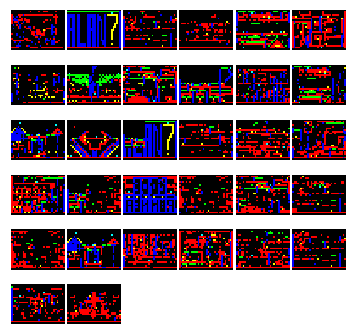

2 th evolution, score_max:1.0, score_min:0.1758,
[0.60879565 0.87847838 0.7201     0.76066338 0.67867143 0.50734638
 0.64112564 0.34187215 0.81828182 0.6057338  0.66676667 0.97412597
 0.42676667 0.9601     0.58984359 0.43047975 0.17577568 0.52335581
 0.48819524 0.52183913 0.48111266 0.62035316 0.51146364 0.64393562
 1.0001     0.51438571 0.30444783 0.68614651 0.90676667 0.46488873
 0.28135    0.49285362]


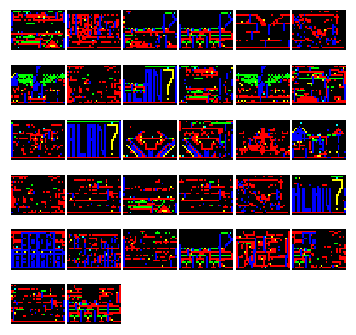

3 th evolution, score_max:1.0, score_min:0.08207,
[0.9048619  0.43966044 0.54421765 0.38471538 0.91035641 0.92967746
 0.58237848 0.73694211 1.0001     0.46763247 0.65832785 0.36718861
 0.91813279 0.82936829 0.64189104 0.46386812 0.49240769 0.53343333
 0.65343333 0.98873636 0.08206721 0.61852105 0.63167895 1.0001
 0.5001     0.59503671 0.72982973 0.56954444 0.95614396 0.55724286
 0.578225   0.73025873]


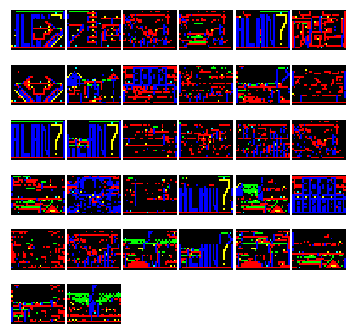

4 th evolution, score_max:1.0, score_min:0.1376,
[0.76414494 0.54176667 0.97152857 0.64295714 0.60304118 0.86429753
 0.75334675 0.61548462 0.65343333 0.64295714 0.51817229 0.88898889
 0.54032989 0.98775432 0.5863069  0.50659351 0.45215479 0.33833529
 0.53856154 0.82768621 0.30995915 0.77951176 0.66676667 0.17731519
 0.64189104 0.1376     0.92232222 0.85067471 0.75290899 0.71242877
 0.86852105 1.0001    ]


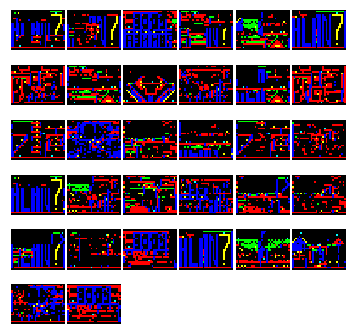

5 th evolution, score_max:1.0, score_min:0.1623,
[0.68614651 0.66226216 0.92317692 0.73249437 0.89343333 0.33343333
 1.0001     0.68065556 0.52574103 0.94604595 0.71676667 0.63865422
 0.8631137  0.39199189 0.38366164 0.63778116 0.57841325 0.57657059
 0.81343333 0.8001     0.59026393 0.8256814  0.58343333 0.62931348
 1.0001     0.16226216 0.77951176 0.93065556 0.90287778 0.47702308
 0.97068824 1.0001    ]


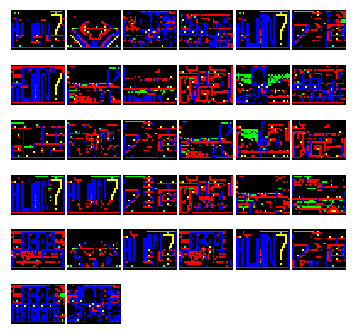

6 th evolution, score_max:1.0, score_min:0.3078,
[0.57904737 0.70598235 0.98658649 0.87351772 0.95955946 0.58833529
 0.89051096 0.91368025 0.89166627 1.0001     0.52552373 0.95190723
 0.30779231 0.70598235 1.0001     0.37152857 0.33343333 0.7751
 0.77021494 0.68431053 0.48581429 0.95955946 0.91964023 0.69421765
 0.76839268 0.82618696 0.97193099 0.70676667 0.8401     0.9301
 0.62800698 0.65442099]


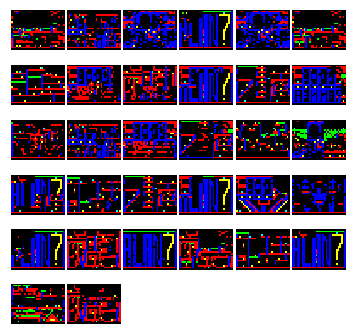

7 th evolution, score_max:1.0, score_min:0.3825,
[0.97684419 0.74334324 0.96062632 0.8751     0.95900411 0.67133288
 0.8453381  0.43671972 0.76200476 0.85304118 0.80908876 0.96395542
 1.0001     0.62676667 0.97657059 0.71062632 0.61914762 0.38245294
 0.82201781 0.72629048 1.0001     0.7001     0.94925254 0.85067471
 1.0001     0.45343333 0.60304118 0.38471538 0.77787778 0.44604595
 0.88898889 0.9001    ]


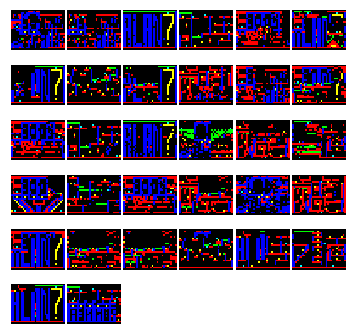

8 th evolution, score_max:1.0, score_min:0.3648,
[0.56954444 0.98676667 0.85517246 0.93660794 1.0001     0.89199189
 0.65126279 0.79421765 1.0001     0.71222121 0.97152857 0.42263521
 0.73144328 0.89865072 0.86966522 0.43253243 0.67098608 0.75591395
 0.41782152 0.36480588 0.98898889 0.98711299 1.0001     0.78581429
 0.55565556 0.75352466 0.46600909 0.93033256 0.37714918 0.98494848
 0.88898889 0.79421765]


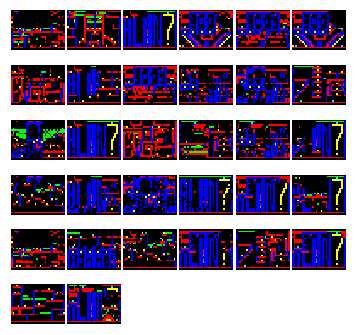

9 th evolution, score_max:1.0, score_min:0.3294,
[0.8359209  1.0001     0.81044483 0.96062632 0.68503151 0.91121111
 0.91559296 0.96713297 0.78031978 0.61981831 1.0001     0.32936829
 0.51438571 0.97445897 0.87333944 0.86373636 0.96933077 0.90919091
 0.7501     0.86966522 0.94530548 0.94057619 0.96062632 1.0001
 0.9126     0.98539412 0.3944662  0.91576265 1.0001     0.7501
 0.5001     0.84625385]


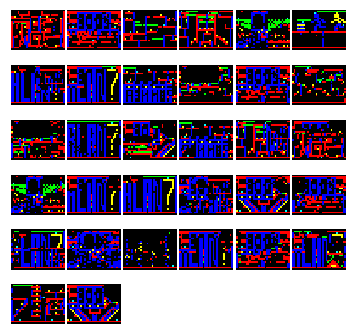

epoch: 6 ,conclusion
raw population


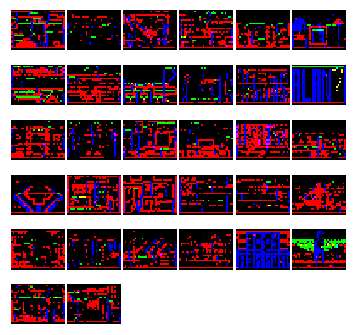

final image


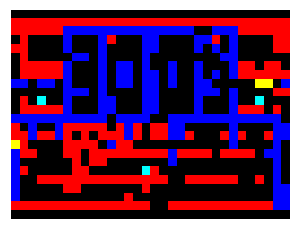

final population


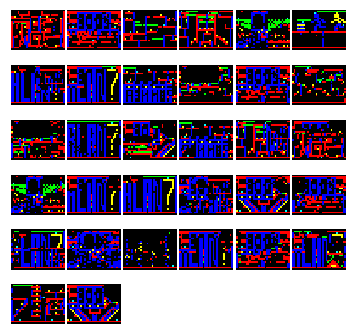

epoch: 7 ,start----------------------------------------------


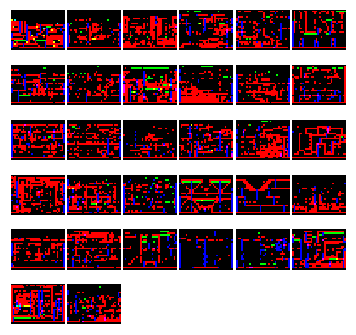

(10000, 24, 32, 5)
0 th evolution, score_max:0.9406, score_min:0.05073,
[0.71804872 0.6747988  0.0953381  0.56906552 0.94057619 0.37372637
 0.08460704 0.71885    0.91676667 0.26933077 0.51292051 0.39782727
 0.20522821 0.09205402 0.26839268 0.21438571 0.23819524 0.26398889
 0.37343333 0.16465696 0.39483684 0.25383134 0.08343333 0.5126
 0.17958718 0.05273158 0.14295714 0.05073291 0.24106386 0.1251
 0.0990011  0.1376    ]
1 th evolution, score_max:0.9366, score_min:0.09221,
[0.44454444 0.64295714 0.28581429 0.30146986 0.74400244 0.3501
 0.7762194  0.87888788 0.20940233 0.26096957 0.18654068 0.19490519
 0.09766098 0.22817018 0.18082289 0.92867143 0.35074935 0.93660794
 0.1885058  0.40253902 0.23539412 0.5916493  0.19240769 0.2626
 0.32921392 0.09220526 0.4751     0.15394615 0.75334675 0.46585342
 0.66676667 0.5001    ]


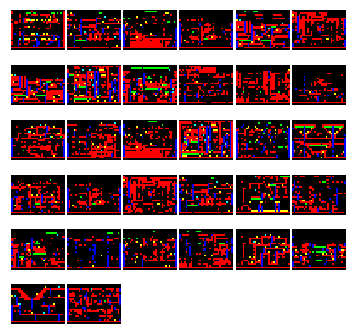

2 th evolution, score_max:0.9596, score_min:0.1559,
[0.24729101 0.69575217 0.15594416 0.26976292 0.31091081 0.46585342
 0.73086923 0.63301139 0.28797879 0.70779231 0.68503151 0.50642911
 0.4001     0.64782727 0.95515618 0.2501     0.27068824 0.88898889
 0.18581429 0.18691319 0.3376     0.95955946 0.4626     0.45955946
 0.52951176 0.30389747 0.23621111 0.56420256 0.7705918  0.25984026
 0.53856154 0.5626    ]


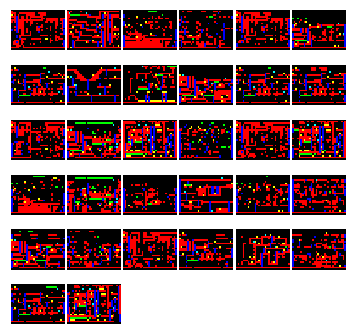

3 th evolution, score_max:0.9837, score_min:0.1487,
[0.2001     0.54555455 0.43912439 0.69364839 0.2501     0.5751
 0.56726418 0.28581429 0.58833529 0.30779231 0.78388378 0.21358315
 0.98370656 0.2501     0.61048961 0.97307297 0.43599744 0.63245294
 0.36056512 0.5626     0.3259427  0.24106386 0.6026641  0.59220526
 0.42038986 0.84715882 0.71438571 0.27787778 0.14874865 0.30444783
 0.34127647 0.39715882]


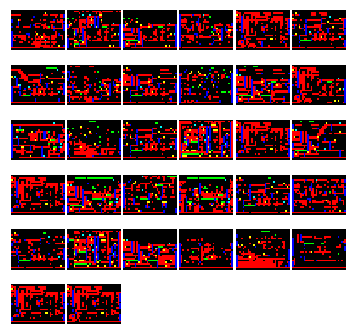

4 th evolution, score_max:0.9566, score_min:0.2026,
[0.53174557 0.7013987  0.46488873 0.57585758 0.6251     0.5001
 0.60820811 0.65863659 0.56800123 0.64874865 0.50676667 0.95662174
 0.34127647 0.51325789 0.22378421 0.20263165 0.26839268 0.32904737
 0.34625385 0.70940233 0.27128644 0.61548462 0.32442432 0.34156341
 0.79497179 0.29278293 0.28135    0.84220526 0.50547634 0.60536316
 0.24667534 0.24647681]


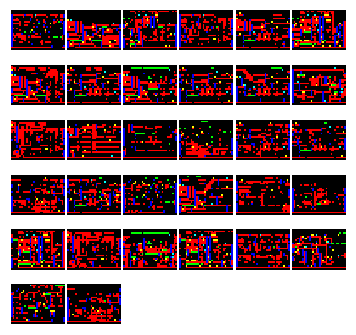

5 th evolution, score_max:0.9776, score_min:0.1623,
[0.39483684 0.84941507 0.30691818 0.6001     0.6001     0.16226216
 0.390725   0.47897324 0.68191818 0.86607938 0.30995915 0.56954444
 0.55233881 0.62274151 0.97762809 0.51861852 0.30892353 0.57327073
 0.57343333 0.62676667 0.5751     0.58581429 0.26933077 0.23297671
 0.83705652 0.8853459  0.48061948 0.52317692 0.38898889 0.69873014
 0.265725   0.47307297]


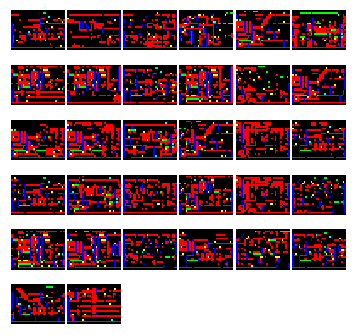

6 th evolution, score_max:0.976, score_min:0.253,
[0.5953381  0.97600361 0.6501     0.49343333 0.70779231 0.26676667
 0.56531739 0.8751     0.56766757 0.82061282 0.55415405 0.57313371
 0.70598235 0.8631137  0.6876     0.82201781 0.68431053 0.54555455
 0.5001     0.49360649 0.85724286 0.6001     0.81924894 0.88069701
 0.89140435 0.25297356 0.57327073 0.65527241 0.36480588 0.76933077
 0.55565556 0.34732222]


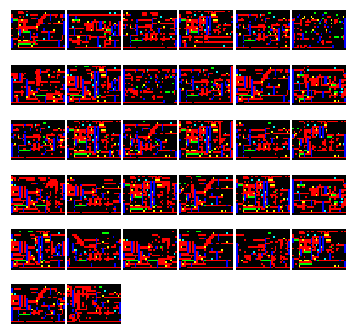

7 th evolution, score_max:0.9631, score_min:0.2395,
[0.58546585 0.3903439  0.90150845 0.61121111 0.4876     0.74334324
 0.65287778 0.69057619 0.5001     0.43830225 0.96306296 0.23953662
 0.84625385 0.69024085 0.63023699 0.8376     0.25892353 0.56531739
 0.734475   0.45464545 0.67083171 0.62830513 0.66676667 0.64393562
 0.7001     0.54421765 0.58833529 0.92217792 0.68141868 0.55565556
 0.93253243 0.82904737]


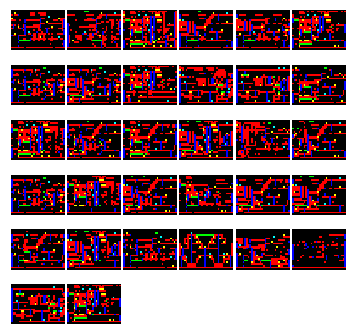

8 th evolution, score_max:0.9495, score_min:0.2677,
[0.47955205 0.9001     0.61653836 0.38471538 0.34454444 0.26770563
 0.81405349 0.81828182 0.63646364 0.94946709 0.35394615 0.91186471
 0.62696567 0.4001     0.44454444 0.91314348 0.75651026 0.5213766
 0.5891411  0.6001     0.3903439  0.58343333 0.64566962 0.46163846
 0.71840986 0.53741343 0.44801667 0.94057619 0.75352466 0.93431053
 0.91559296 0.68263968]


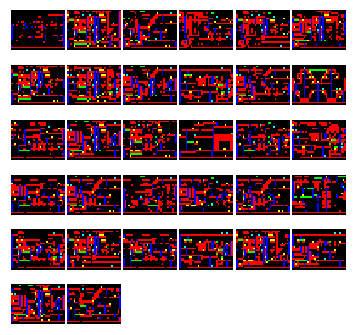

9 th evolution, score_max:0.9734, score_min:0.3374,
[0.73249437 0.3374494  0.97343333 0.9001     0.58118108 0.85892353
 0.39782727 0.78957368 0.61121111 0.94604595 0.97232222 0.74334324
 0.54676667 0.5916493  0.9376     0.44165844 0.4001     0.46438571
 0.67577568 0.72068824 0.56972025 0.80908876 0.57657059 0.59766098
 0.66314348 0.5061241  0.48494848 0.80529481 0.63105238 0.47836087
 0.77343333 0.67958718]


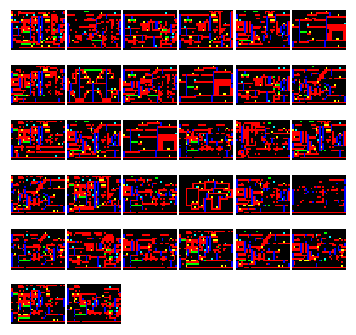

epoch: 7 ,conclusion
raw population


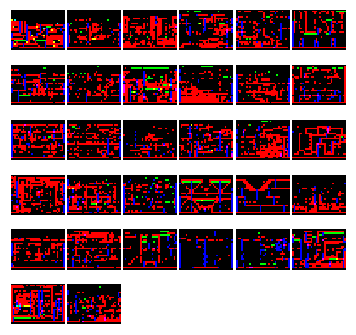

final image


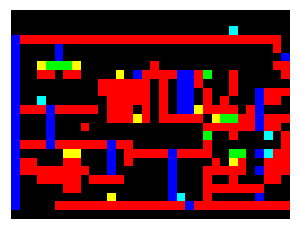

final population


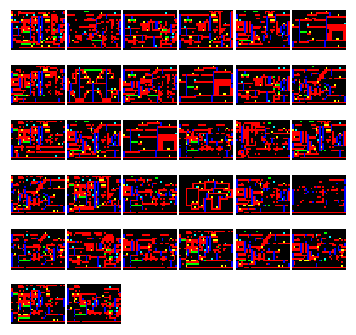

epoch: 8 ,start----------------------------------------------


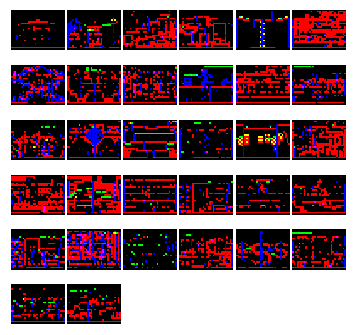

(10000, 24, 32, 5)
0 th evolution, score_max:0.9482, score_min:0.06677,
[0.62328841 0.93343333 0.43539412 0.94815195 0.24701358 0.87664321
 0.54771905 0.12641579 0.20598235 0.1885058  0.44575217 0.44746842
 0.35453038 0.26976292 0.89665172 0.88617595 0.36517937 0.34792609
 0.68051237 0.07256377 0.1012236  0.16226216 0.08984359 0.26754186
 0.07802208 0.10724286 0.11774706 0.1251     0.07238916 0.08149535
 0.15863659 0.06676667]
1 th evolution, score_max:0.9847, score_min:0.05138,
[0.32936829 0.42038986 0.27282727 0.79555455 0.5876     0.98471538
 0.93431053 0.20248095 0.44127647 0.05138205 0.87814878 0.05415405
 0.24519804 0.1251     0.87681233 0.29079767 0.15287778 0.65527241
 0.26976292 0.59766098 0.44313797 0.4940759  0.93680886 0.40239885
 0.53668537 0.53942584 0.11637907 0.21062632 0.06676667 0.29860746
 0.14676667 0.09100909]


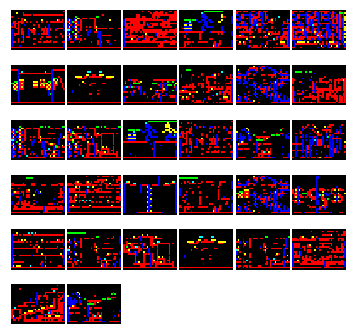

2 th evolution, score_max:0.9601, score_min:0.1128,
[0.49325068 0.92692927 0.49325068 0.86676667 0.23386623 0.17731519
 0.9048619  0.18191818 0.86496486 0.296975   0.41548462 0.85273158
 0.54555455 0.65635    0.25685676 0.28419091 0.91790822 0.23738814
 0.26037397 0.43949394 0.62972963 0.15863659 0.61548462 0.18431053
 0.24252424 0.11277606 0.44881795 0.63167895 0.89199189 0.5126
 0.9601     0.67615634]


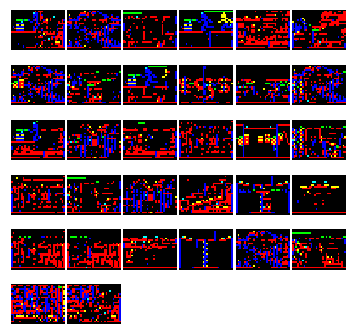

3 th evolution, score_max:0.9307, score_min:0.09887,
[0.88415797 0.92073492 0.09886543 0.20699655 0.51229512 0.68614651
 0.45892353 0.5626     0.64625385 0.64207531 0.65863659 0.1972831
 0.4501     0.79785281 0.41782152 0.84941507 0.90133457 0.3374494
 0.88774045 0.24454444 0.5001     0.77429355 0.25724286 0.7312828
 0.48111266 0.44272295 0.2401     0.83793784 0.4788234  0.93065556
 0.85343333 0.80529481]


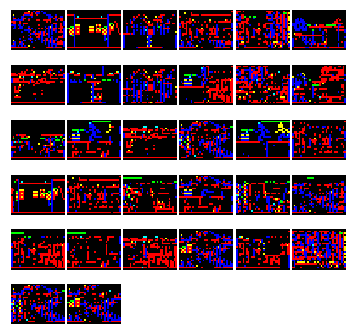

4 th evolution, score_max:0.9325, score_min:0.1586,
[0.8990899  0.4001     0.8626     0.7501     0.6376     0.64393562
 0.20522821 0.85195185 0.65763425 0.77787778 0.88167895 0.93113448
 0.7251     0.88053478 0.92692927 0.8626     0.91035641 0.8022978
 0.80962381 0.36718861 0.92415063 0.80779231 0.5001     0.40360877
 0.15863659 0.49263731 0.26605745 0.17152857 0.43253243 0.6876
 0.51229512 0.93253243]


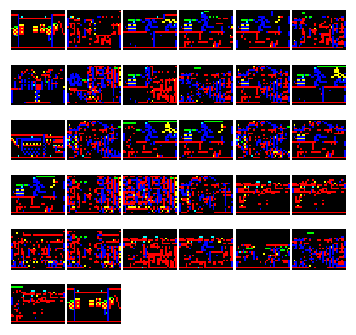

5 th evolution, score_max:0.9596, score_min:0.3539,
[0.90133457 0.70896076 0.92415063 0.78323253 0.72982973 0.89865072
 0.64483684 0.8962039  0.78581429 0.91149241 0.46438571 0.94454444
 0.63390282 0.48324607 0.92967746 0.51438571 0.73086923 0.87664321
 0.69630253 0.76398889 0.47897324 0.6501     0.77282727 0.88415797
 0.95955946 0.67542468 0.52641579 0.67174179 0.95565556 0.89715882
 0.8501     0.35394615]


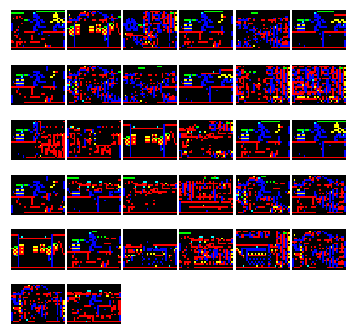

6 th evolution, score_max:0.9664, score_min:0.3751,
[0.79797234 0.44328182 0.74657887 0.6548619  0.8989764  0.68191818
 0.93558387 0.94127647 0.66676667 0.67657059 0.66676667 0.53174557
 0.69328182 0.93985904 0.73144328 0.89562239 0.54032989 0.86216897
 0.8751     0.63523514 0.73819524 0.77641579 0.95955946 0.73427722
 0.89166627 0.3751     0.64295714 0.53343333 0.66226216 0.85536316
 0.93431053 0.96639213]


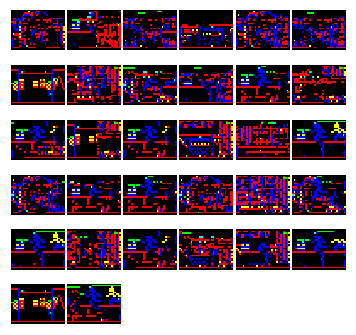

7 th evolution, score_max:0.9727, score_min:0.3057,
[0.85116383 0.75651026 0.83793784 0.81588947 0.85195185 0.76200476
 0.73982603 0.73694211 0.41035641 0.68503151 0.61548462 0.89665172
 0.8126     0.36595366 0.7013987  0.88617595 0.7973973  0.62205122
 0.92602593 0.9126     0.3909046  0.85536316 0.3881597  0.80779231
 0.53174557 0.91121111 0.97270274 0.30565556 0.93985904 0.71438571
 0.72125385 0.93599744]


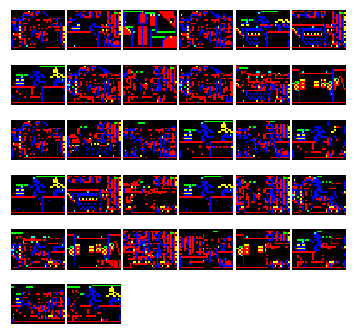

8 th evolution, score_max:0.9553, score_min:0.09101,
[0.36154578 0.86676667 0.85343333 0.81828182 0.7001     0.67577568
 0.6970697  0.93343333 0.69630253 0.78833529 0.09100909 0.5891411
 0.88245294 0.95532388 0.8903439  0.72951176 0.43688161 0.94328182
 0.7261274  0.8126     0.8801     0.79022346 0.8751     0.90707674
 0.94454444 0.94039851 0.93516494 0.85879565 0.92692927 0.91676667
 0.86676667 0.16676667]


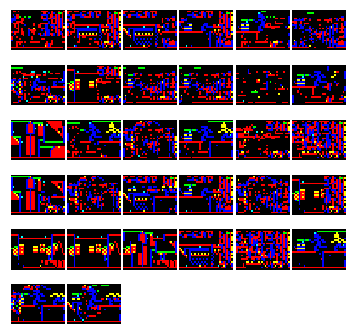

9 th evolution, score_max:0.984, score_min:0.3426,
[0.90919091 0.92217792 0.89865072 0.96521628 0.94127647 0.98397097
 0.69454444 0.34256575 0.74613175 0.80565556 0.75304118 0.8601
 0.5626     0.86756988 0.94127647 0.6251     0.86966522 0.87189487
 0.88742394 0.93416593 0.78215128 0.91054776 0.92737273 0.78471538
 0.76933077 0.95900411 0.60724286 0.68928919 0.82288481 0.79375079
 0.89782727 0.66243766]


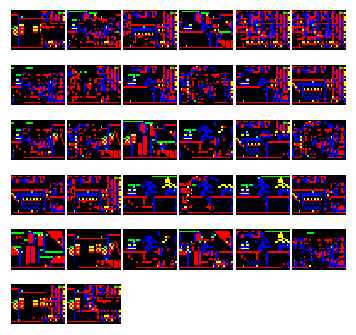

epoch: 8 ,conclusion
raw population


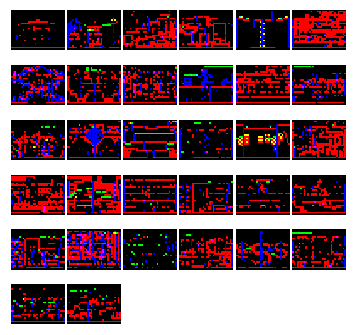

final image


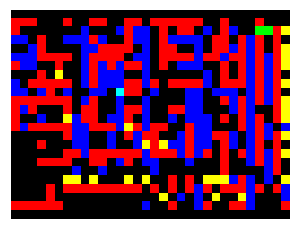

final population


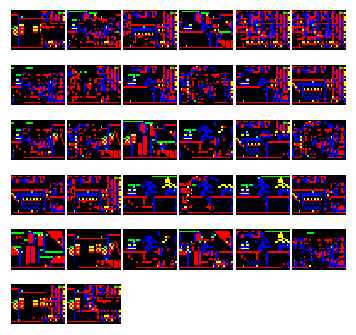

epoch: 9 ,start----------------------------------------------


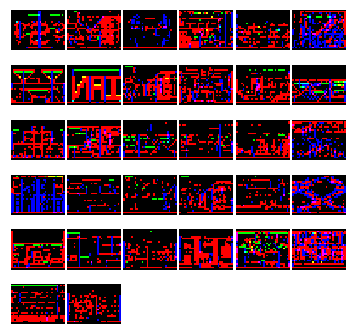

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.02951,
[0.06503506 1.0001     0.43599744 1.0001     0.21222121 0.81531739
 0.18833529 0.6098561  0.84517042 0.37343333 0.24625385 0.74127647
 0.90287778 0.3254012  0.47702308 0.56107561 0.15287778 0.69024085
 0.58581429 0.72849506 0.04357826 0.56636506 0.44625385 0.70779231
 0.20491928 0.70896076 0.2279481  0.09886543 0.11914762 0.08229178
 0.14295714 0.02951176]
1 th evolution, score_max:0.9013, score_min:0.143,
[0.62972963 0.37047037 0.37888788 0.24647681 0.5001     0.62305082
 0.79357826 0.8031303  0.75352466 0.5001     0.27282727 0.19111124
 0.7827087  0.69364839 0.4801     0.88105238 0.5953381  0.2001
 0.34949759 0.90133457 0.25619756 0.73982603 0.85375854 0.75591395
 0.65799474 0.63390282 0.65343333 0.453225   0.8251     0.14295714
 0.49305775 0.78676667]


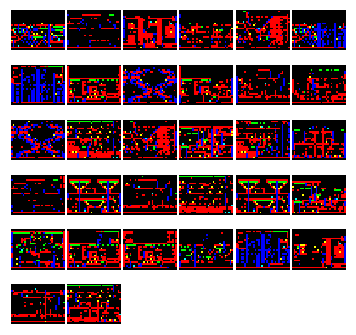

2 th evolution, score_max:0.9741, score_min:0.1012,
[0.24334324 0.97412597 0.83060847 0.67867143 0.6836443  0.73621111
 0.77037027 0.4001     0.32936829 0.90133457 0.77343333 0.44096022
 0.4376     0.41870465 0.48727949 0.20248095 0.48727949 0.1012236
 0.77641579 0.38281605 0.92434242 0.16226216 0.7501     0.95131951
 0.86914762 0.46676667 0.73982603 0.64644146 0.78491013 0.63646364
 0.46521628 0.17731519]


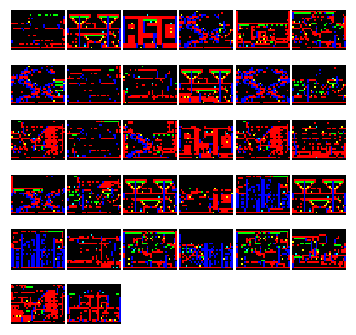

3 th evolution, score_max:0.9601, score_min:0.2389,
[0.90779231 0.7501     0.78491013 0.43949394 0.69328182 0.94127647
 0.94604595 0.84220526 0.78491013 0.77787778 0.23890597 0.8501
 0.44937536 0.64207531 0.92434242 0.7501     0.31878132 0.88898889
 0.54955055 0.84067971 0.80892353 0.72378421 0.63778116 0.6001
 0.81022658 0.63424634 0.7501     0.9601     0.5626     0.6970697
 0.2963963  0.93160685]


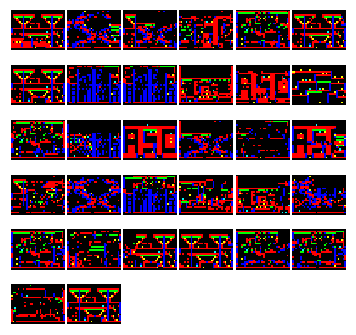

4 th evolution, score_max:0.9656, score_min:0.2942,
[0.71094337 0.85536316 0.77904737 0.5001     0.68503151 0.80831918
 0.52093333 0.77343333 0.296975   0.54330988 0.8001     0.85974912
 0.94604595 0.83343333 0.91790822 0.7655321  0.44786119 0.79230779
 0.29421765 0.84295714 0.50676667 0.93343333 0.5444038  0.96561724
 0.82061282 0.88415797 0.85195185 0.92657059 0.95412299 0.83108592
 0.79555455 0.87022987]


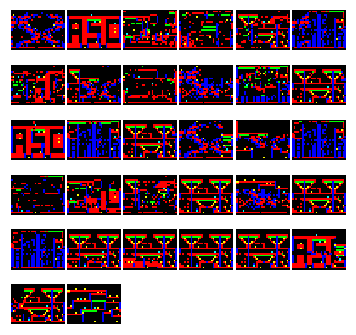

5 th evolution, score_max:0.986, score_min:0.1236,
[0.78797879 0.62676667 0.92434242 0.67542468 0.78883239 0.9001
 0.67174179 0.91676667 0.89343333 0.13343333 0.5751     0.27916977
 0.8975359  0.81937711 0.75651026 0.75565556 0.7028027  0.93113448
 0.31335301 0.26325789 0.45987011 0.98601549 0.90420959 0.81365932
 0.89562239 0.93680886 0.94295714 0.12355679 0.8989764  0.91473415
 0.70896076 0.62232222]


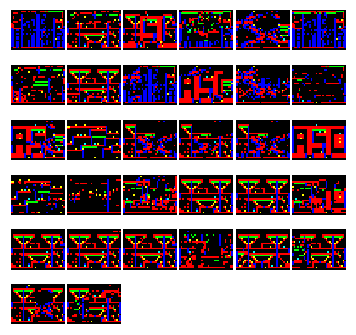

6 th evolution, score_max:1.0, score_min:0.3872,
[0.94815195 0.8962039  0.87681233 0.71840986 0.85304118 0.92602593
 0.92602593 0.8751     0.70464545 0.93694211 0.63646364 0.79462055
 0.75278817 0.79230779 0.9626     0.75565556 0.8751     0.8801
 0.81828182 0.65178539 0.38719677 0.61852105 0.42038986 0.5001
 0.953225   0.77021494 1.0001     0.79042258 0.91576265 0.39769036
 0.96351463 0.91499362]


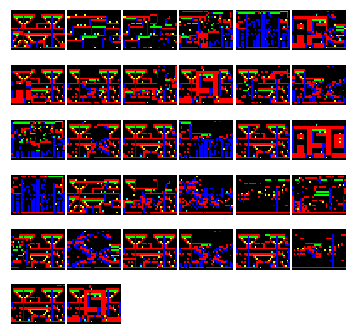

7 th evolution, score_max:0.9864, score_min:0.1958,
[0.59560562 0.90133457 0.83108592 0.89665172 0.93160685 0.77152857
 0.87961807 0.98640137 0.73025873 0.64054944 0.83918046 0.8173043
 0.92967746 0.83343333 0.93033256 0.91438571 0.92602593 0.8376
 0.61186471 0.88053478 0.77282727 0.67401304 0.9601     0.36629718
 0.82964545 0.7501     0.7756102  0.19575217 0.71774706 0.60684157
 0.95598235 0.97270274]


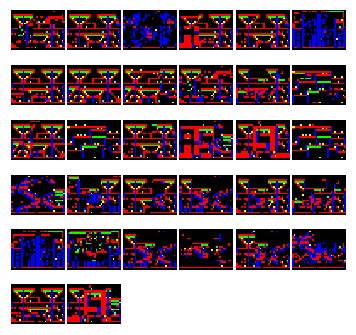

8 th evolution, score_max:0.9757, score_min:0.3952,
[0.73856154 0.65287778 0.88053478 0.9001     0.65227391 0.84893721
 0.97570976 0.53174557 0.93343333 0.92317692 0.71840986 0.53531127
 0.94328182 0.85724286 0.74084074 0.89343333 0.91035641 0.89665172
 0.90814598 0.9011989  0.39516173 0.87351772 0.90133457 0.93431053
 0.92657059 0.64140435 0.66676667 0.8126     0.87106774 0.79042258
 0.69343333 0.9001    ]


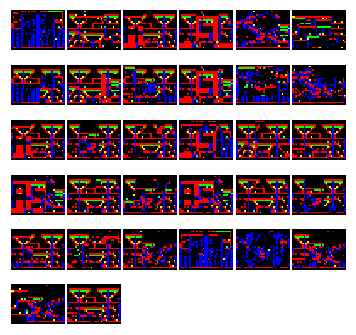

9 th evolution, score_max:0.964, score_min:0.2728,
[0.93268427 0.96395542 0.59100909 0.72629048 0.74368974 0.63424634
 0.80861064 0.93065556 0.94392022 0.8853459  0.9201     0.91314348
 0.89865072 0.7261274  0.93516494 0.7001     0.92967746 0.96062632
 0.51774706 0.93268427 0.92217792 0.93113448 0.82288481 0.62305082
 0.91035641 0.9251     0.89403939 0.7201     0.90394615 0.27282727
 0.68488261 0.69575217]


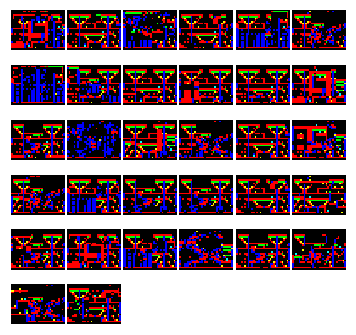

epoch: 9 ,conclusion
raw population


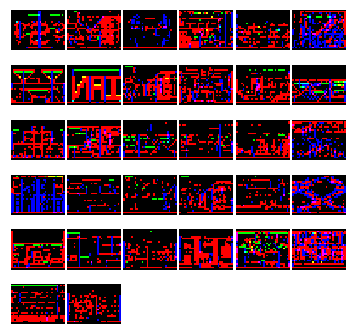

final image


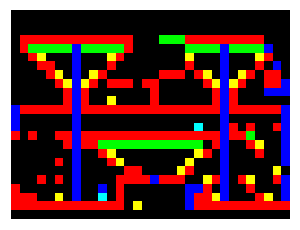

final population


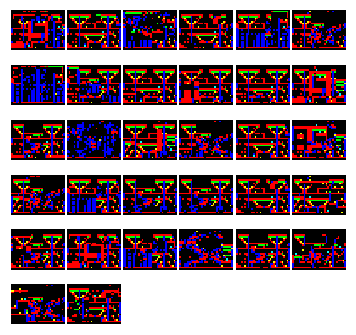

------------final round------------
(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.9001,
[0.93680886 0.91676667 1.0001     1.0001     1.0001     1.0001
 0.9001     0.96784194 0.92217792 1.0001    ]
1 th evolution, score_max:1.0, score_min:0.8852,
[0.9601     0.93160685 0.97024925 1.0001     0.88515747 0.89715882
 0.89715882 0.98819524 0.94881795 0.98539412]


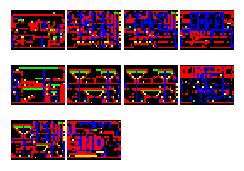

2 th evolution, score_max:1.0, score_min:0.8838,
[0.95955946 0.94454444 0.93516494 0.88382093 0.96600909 0.92692927
 0.98790488 0.95662174 0.9123807  1.0001    ]


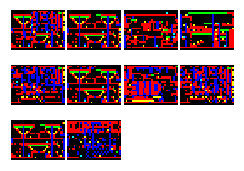

3 th evolution, score_max:1.0, score_min:0.8796,
[1.0001     0.88515747 1.0001     0.95900411 0.96521628 0.89562239
 0.87961807 0.98819524 0.95955946 0.94262874]


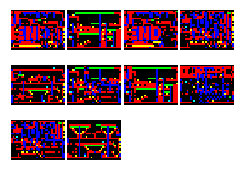

4 th evolution, score_max:0.986, score_min:0.8501,
[0.91945484 0.88581429 0.98601549 0.94881795 0.8501     0.91813279
 0.95071728 0.89240769 0.98539412 0.95071728]


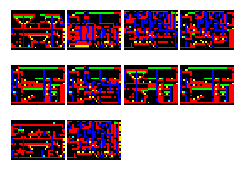

5 th evolution, score_max:0.9849, score_min:0.1269,
[0.92763623 0.90420959 0.98494848 0.96395542 0.97445897 0.93253243
 0.8989764  0.12686056 0.92951176 0.94196047]


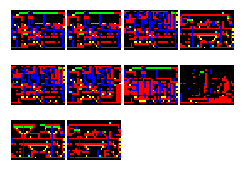

6 th evolution, score_max:0.9849, score_min:0.6054,
[0.97445897 0.94057619 0.87702308 0.90814598 0.98494848 0.97540864
 0.90919091 0.60536316 0.91945484 0.92951176]


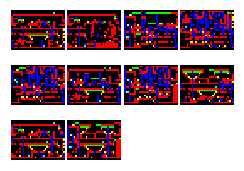

7 th evolution, score_max:0.9889, score_min:0.7501,
[0.91054776 0.92967746 0.9501     0.90635    0.96306296 0.92602593
 0.83156067 0.7501     0.9601     0.98886404]


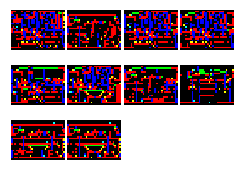

8 th evolution, score_max:0.9748, score_min:0.7163,
[0.71631622 0.97478354 0.96351463 0.96676667 0.93856154 0.97152857
 0.8751     0.9501     0.9383716  0.7762194 ]


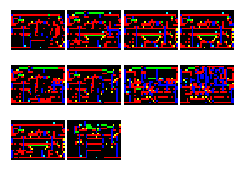

9 th evolution, score_max:1.0, score_min:0.8572,
[0.9376     1.0001     0.95131951 0.8903439  0.88415797 0.92115263
 0.85724286 0.97024925 0.9626     0.97307297]


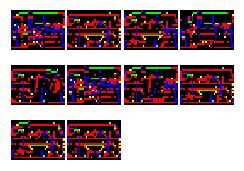

10 th evolution, score_max:0.9572, score_min:0.4707,
[0.94376197 0.90799474 0.90253902 0.90799474 0.89483684 0.92967746
 0.93949394 0.91314348 0.47068824 0.95724286]


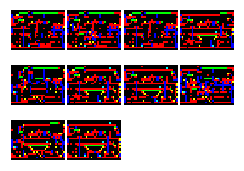

11 th evolution, score_max:0.9495, score_min:0.5845,
[0.93253243 0.89051096 0.58451558 0.90150845 0.86373636 0.91559296
 0.91121111 0.94946709 0.93599744 0.93160685]


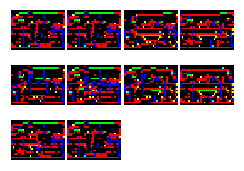

12 th evolution, score_max:0.976, score_min:0.8751,
[0.90676667 0.95662174 0.91901892 0.95843333 0.94262874 0.97600361
 0.8751     0.89051096 0.96306296 0.9126    ]


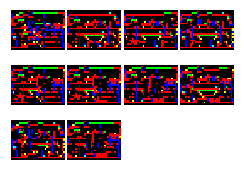

13 th evolution, score_max:0.9596, score_min:0.8796,
[0.95955946 0.93268427 0.9001     0.90919091 0.94881795 0.94057619
 0.87961807 0.91368025 0.94746842 0.94881795]


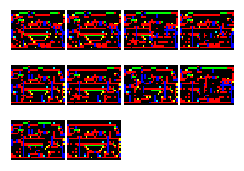

14 th evolution, score_max:0.9621, score_min:0.8876,
[0.8876     0.94127647 0.9126     0.96212532 0.94392022 0.90598235
 0.89883418 0.93488261 0.91438571 0.94295714]


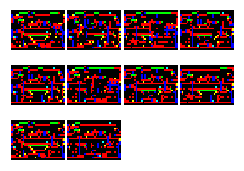

15 th evolution, score_max:0.9546, score_min:0.9015,
[0.93160685 0.93343333 0.95464545 0.90150845 0.94946709 0.94212899
 0.91035641 0.95248095 0.94127647 0.9376    ]


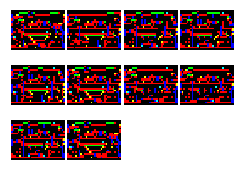

16 th evolution, score_max:0.9525, score_min:0.1501,
[0.8962039  0.93599744 0.90799474 0.54555455 0.94295714 0.90676667
 0.95248095 0.1501     0.91945484 0.8126    ]


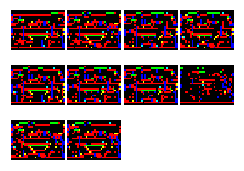

17 th evolution, score_max:1.0, score_min:0.08461,
[0.79278293 0.81828182 0.91368025 0.08460704 0.97152857 0.828225
 0.88742394 0.98539412 1.0001     0.51658352]


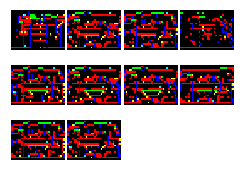

18 th evolution, score_max:0.9399, score_min:0.5876,
[0.78092192 0.89343333 0.88581429 0.89865072 0.8314253  0.63539412
 0.93856154 0.8001     0.93985904 0.5876    ]


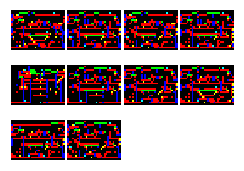

19 th evolution, score_max:0.9719, score_min:0.2531,
[0.92763623 0.69127647 0.77152857 0.25311205 0.97193099 0.95598235
 0.86496486 0.92951176 0.91314348 0.53942584]


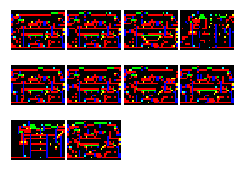

20 th evolution, score_max:0.9849, score_min:0.6906,
[0.86577164 0.88471538 0.69057619 0.93160685 0.79756835 0.91559296
 0.75651026 0.98494848 0.75872069 0.73780492]


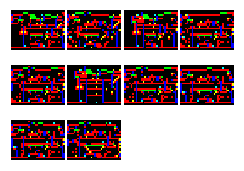

21 th evolution, score_max:0.9453, score_min:0.6978,
[0.89883418 0.82099552 0.8022978  0.90598235 0.69777442 0.94530548
 0.92217792 0.7805878  0.7376     0.82099552]


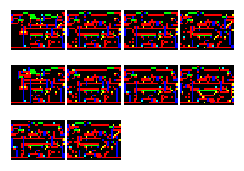

22 th evolution, score_max:0.946, score_min:0.7106,
[0.94604595 0.92317692 0.73856154 0.71062632 0.78491013 0.84156341
 0.92967746 0.93253243 0.79176667 0.73621111]


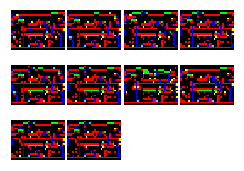

23 th evolution, score_max:0.943, score_min:0.3601,
[0.94295714 0.74676667 0.8031303  0.71242877 0.88415797 0.89199189
 0.3601     0.78323253 0.67356939 0.64207531]


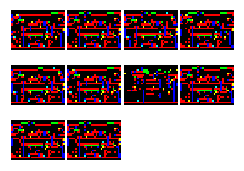

24 th evolution, score_max:0.9546, score_min:0.5659,
[0.56588947 0.95464545 0.75913614 0.71774706 0.86878687 0.7501
 0.75541915 0.81121111 0.93033256 0.74676667]


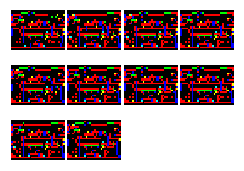

25 th evolution, score_max:0.8126, score_min:0.6989,
[0.8126     0.70432535 0.7817092  0.7376     0.75372319 0.73224286
 0.80831918 0.69889518 0.79391443 0.78135   ]


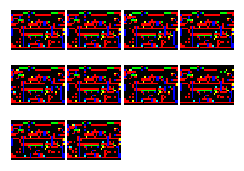

26 th evolution, score_max:0.8244, score_min:0.6876,
[0.78471538 0.71614938 0.69873014 0.78676667 0.72473768 0.7751
 0.80242558 0.6876     0.82442432 0.7973973 ]


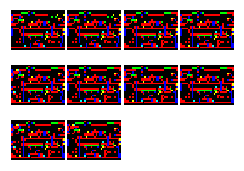

27 th evolution, score_max:0.8801, score_min:0.7408,
[0.7805878  0.76795714 0.76839268 0.75872069 0.78471538 0.74084074
 0.8801     0.74368974 0.78323253 0.77787778]


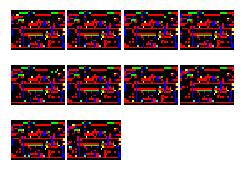

28 th evolution, score_max:0.8112, score_min:0.2064,
[0.75318642 0.72737273 0.6801     0.81121111 0.70896076 0.7753809
 0.20644921 0.7501     0.77429355 0.42692927]


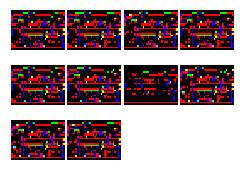

29 th evolution, score_max:0.8422, score_min:0.3825,
[0.84220526 0.78491013 0.38245294 0.75591395 0.7973973  0.7805878
 0.41343333 0.80962381 0.80831918 0.76414494]


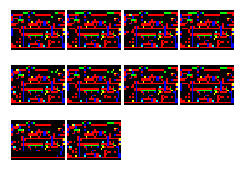

30 th evolution, score_max:0.8159, score_min:0.7404,
[0.8001     0.74035974 0.77657059 0.81588947 0.74334324 0.76754186
 0.79671017 0.80565556 0.79320345 0.75448596]


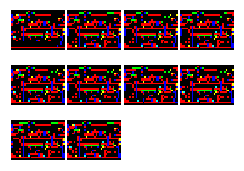

31 th evolution, score_max:0.854, score_min:0.6858,
[0.73982603 0.8314253  0.71651791 0.79756835 0.85403258 0.7013987
 0.78135    0.70248095 0.68581429 0.69889518]


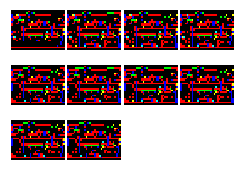

32 th evolution, score_max:0.8057, score_min:0.6801,
[0.72174948 0.73694211 0.77343333 0.6801     0.75724286 0.71024493
 0.68928919 0.8001     0.80273158 0.80565556]


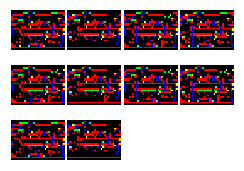

33 th evolution, score_max:0.8126, score_min:0.442,
[0.68841169 0.8001     0.78883239 0.8126     0.75591395 0.44196047
 0.80732892 0.79130879 0.71438571 0.73503976]


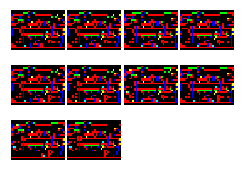

34 th evolution, score_max:0.843, score_min:0.203,
[0.82201781 0.84295714 0.7501     0.77932078 0.7805878  0.7376
 0.71651791 0.84295714 0.20299855 0.55565556]


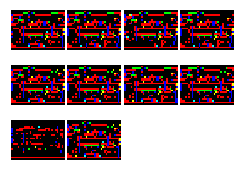

35 th evolution, score_max:0.8489, score_min:0.3001,
[0.77951176 0.82362941 0.3001     0.84625385 0.84893721 0.72299157
 0.69127647 0.70843333 0.75352466 0.76200476]


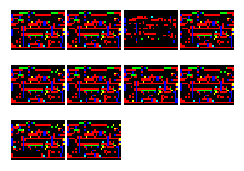

36 th evolution, score_max:0.8373, score_min:0.6754,
[0.8373093  0.75352466 0.76722329 0.67542468 0.73573218 0.734475
 0.82442432 0.69454444 0.76839268 0.72951176]


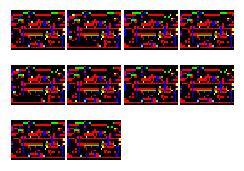

37 th evolution, score_max:0.8593, score_min:0.6906,
[0.72982973 0.74693544 0.72737273 0.69057619 0.7805878  0.70779231
 0.78957368 0.85925493 0.77152857 0.71651791]


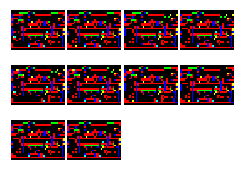

38 th evolution, score_max:0.8149, score_min:0.7001,
[0.73180732 0.70222766 0.81491481 0.74454444 0.73144328 0.76722329
 0.79230779 0.71885    0.79042258 0.7001    ]


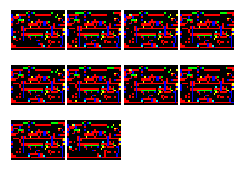

39 th evolution, score_max:0.8554, score_min:0.7163,
[0.71631622 0.73747374 0.85536316 0.75394615 0.85145135 0.72473768
 0.71840986 0.8029169  0.80691818 0.77932078]


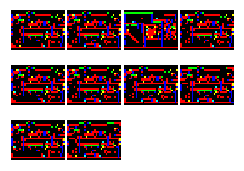

raw population


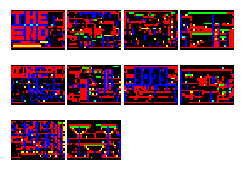

final image


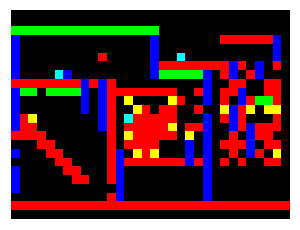

final population


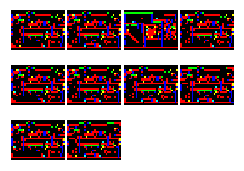

final level candate


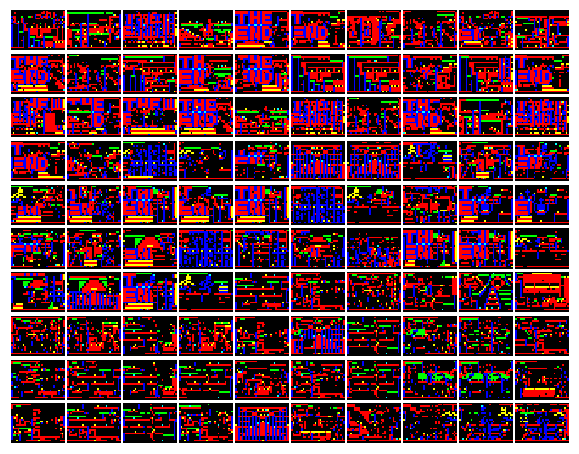

In [7]:
#evo param
evo_in_path = "e://python3/vae_v3.npy"
crossover_rate = 0.9
mutate_rate = 0.1
n_population = 32
n_iterations = 10   #total iteration = (9+1)*3=30  #time complexity = 30*3*9* O(Astar)= (np*ni)**2 *astar
#------------------------------------------------------------------
rawset = np.load(evo_in_path)
np.random.shuffle(rawset)

#data = np.random.randint(0,2,size=(n_population,DNA_size)).astype(np.int8)
extra_set = []
final_set = []
st = 0

for i in range(10):  #n_population
    print('epoch:',i,',start----------------------------------------------')
    idx = np.random.choice(np.arange(rawset.shape[0]), size=n_population, replace=False)
    img_in = rawset[idx]
    Util.disp_images(img_in) 
    gene = Util.img2gene(img_in)   
    ga = Generic(gene,rawset=rawset,crossover_rate=crossover_rate,mutate_rate = mutate_rate,n_population=n_population,
                  DNA_size=gb_w*gb_h*gb_c, n_iterations = n_iterations)
    ga.evolution()
    print('epoch:',i,',conclusion')
    print('raw population')
    Util.disp_images(img_in) 
    print('final image')
    Util.disp_images(ga.best_person.reshape([1,-1]),figsize=(5,4)) 
    print('final population')
    Util.disp_images(ga.population) 
    final_set,st = (np.vstack((final_set,ga.population)),1) if st==1 else (ga.population,1)
    extra_set.append(ga.best_person)
    
print('------------final round------------')
ga = Generic(np.array(extra_set),rawset=rawset,crossover_rate=crossover_rate,mutate_rate = mutate_rate,n_population=min(len(extra_set),n_population),
                  DNA_size=gb_w*gb_h*gb_c, n_iterations = n_iterations*4)
ga.evolution()

print('raw population')
Util.disp_images(np.array(extra_set)) 

print('final image')
Util.disp_images(ga.best_person.reshape([1,-1]),figsize=(5,4)) 
print('final population')
Util.disp_images(ga.population) 

final_set = np.vstack((final_set,ga.population))
print('final level candate')
Util.disp_images(np.array(final_set).reshape([-1,gb_w*gb_h*gb_c]),figsize=(10.0, 8.0)) 
np.save("evolution_v5",np.array(final_set).reshape([-1,gb_w*gb_h*gb_c]),allow_pickle=False,fix_imports=True)


(330, 3840)


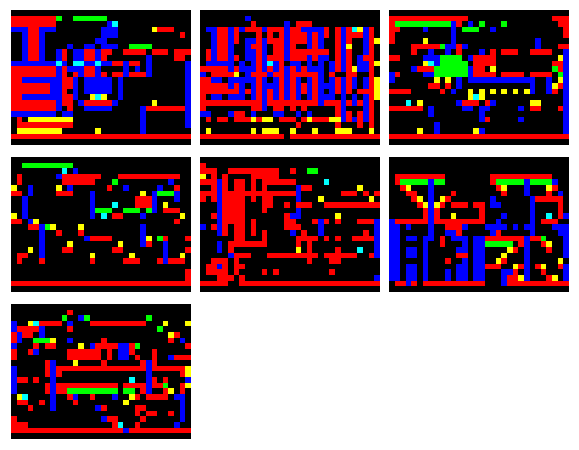

In [56]:
sth = np.load("e://python3/evolution_v5.npy")
print(sth.shape)
#np.random.shuffle(sth)
wanted = sth[[48,29,137,203,240,314,324]]
_ = disp_images(wanted,figsize=(10.0, 8.0))


(300, 24, 32, 5)
(330, 24, 32, 5)


e:\learning software\python\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


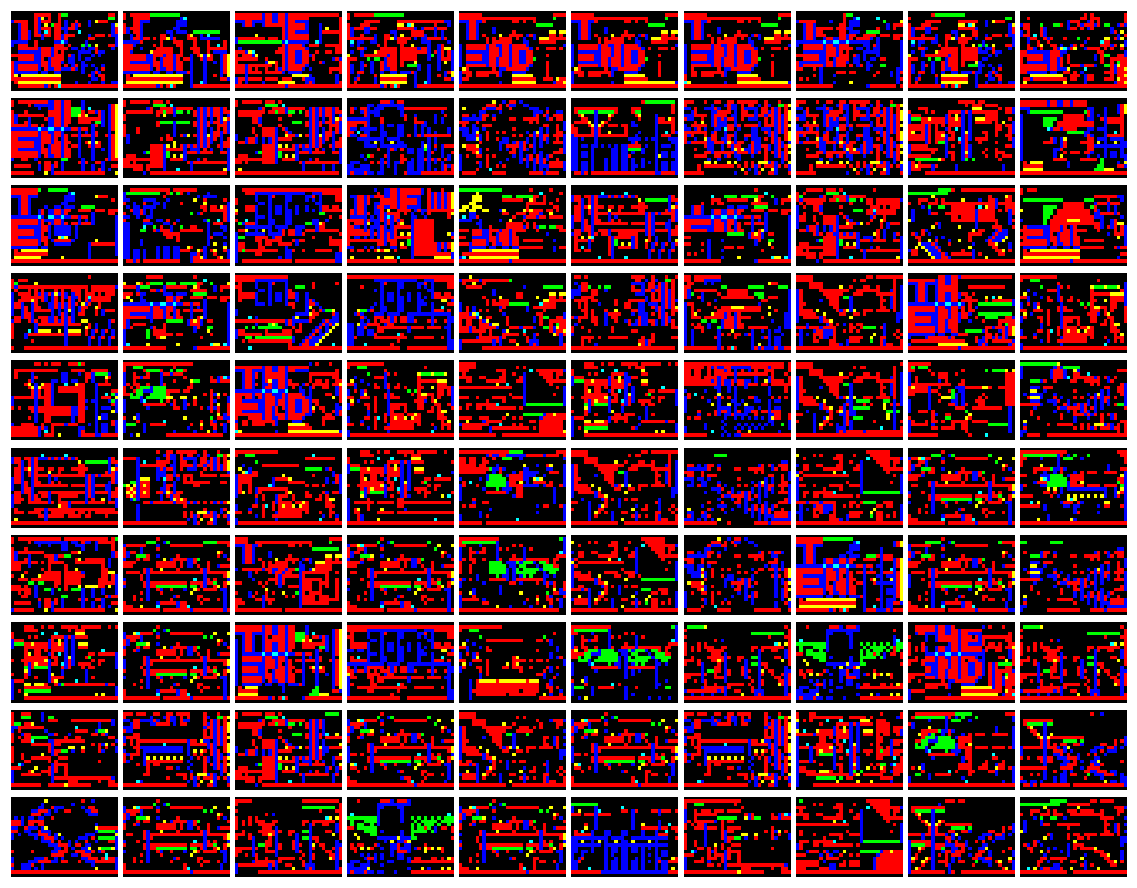

[0.52734375 0.54296875 0.54947917 0.55598958 0.5625     0.56510417
 0.56510417 0.56901042 0.57161458 0.57291667 0.58072917 0.59114583
 0.59375    0.59505208 0.59895833 0.60286458 0.60416667 0.60416667
 0.609375   0.609375   0.609375   0.61458333 0.61458333 0.61458333
 0.6171875  0.61848958 0.62239583 0.62239583 0.62239583 0.625
 0.625      0.625      0.625      0.62630208 0.62760417 0.62890625
 0.62890625 0.63151042 0.63411458 0.63411458 0.63802083 0.63932292
 0.640625   0.640625   0.64192708 0.64453125 0.64453125 0.64713542
 0.64713542 0.6484375  0.6484375  0.6484375  0.6484375  0.65104167
 0.65234375 0.65364583 0.65494792 0.65494792 0.65494792 0.65494792
 0.65625    0.65625    0.65755208 0.65755208 0.65755208 0.65755208
 0.65885417 0.65885417 0.65885417 0.66015625 0.66145833 0.66145833
 0.66276042 0.66276042 0.6640625  0.6640625  0.6640625  0.6640625
 0.6640625  0.6640625  0.66536458 0.66536458 0.66536458 0.66536458
 0.66536458 0.66536458 0.66536458 0.66666667 0.66666667 0.66666667
 

In [67]:
imageMatrix1 = np.load(input_path)[:150]
imageMatrix2 = data_augumentation(imageMatrix1)
imageMatrix1 = np.vstack((imageMatrix1,imageMatrix2))
imageMatrix1 = imageMatrix1[0:300]  #----------------------------------
base = imageMatrix1[:300].copy()
test = sth.reshape([-1,24,32,5]).copy()

print(base.shape)
print(test.shape)
saved_base = base
saved_test = test

ec_imglist1 = []
for i in range(base.shape[0]):
    #print('process ',i)
    ec_img, _ = Util.encoding_img(base[i])
    ec_imglist1.append(ec_img)
ec_imglist1 = np.array(ec_imglist1)
base = ec_imglist1


ec_imglist2 = []
for i in range(test.shape[0]):
    #print('process ',i)
    ec_img, _  = Util.encoding_img(test[i])
    ec_imglist2.append(ec_img)
ec_imglist2 = np.array(ec_imglist2)
test = ec_imglist2


base[base==0] = 10
res = []
for t in test:
    similarmax = 0
    for b in base:
        similarmax = max(similarmax,np.mean(t==b))
    res.append(similarmax)

res = np.array(res)
_ = disp_images(saved_test[np.argsort(res)],figsize=(20.0, 16.0))
print(np.abs(np.sort(res)))